In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/AMC')

In [ ]:
# !tar xvjf /content/drive/MyDrive/AMC/RML2016.10b.tar.bz2 -C /content/drive/MyDrive/AMC/


In [ ]:
import pickle
import numpy as np

class DataLoader:
    def __init__(self, filename):
        self.filename = filename
        self.p = self.load_data()

    def load_data(self):
        with open(self.filename, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            p = u.load()
        return p

    def get_data(self):
        snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], self.p.keys())))), [1, 0])

        X = []
        lbl = []
        Z = []
        for mod in mods:
            for snr in snrs:
                X.append(self.p[(mod, snr)])
                for i in range(self.p[(mod, snr)].shape[0]):
                    lbl.append((mod, snr))
                    Z.append(snr)

        X = np.vstack(X)
        Z = np.vstack(Z)

        return X, Z, lbl, snrs, mods


In [ ]:
dataset_load = DataLoader('/content/drive/MyDrive/AMC/RML2016.10b.dat')
X,Z,lbl, snrs, mods = dataset_load.get_data()

In [ ]:
np.random.seed(2016)
n_examples = int(X.shape[0])

# Define proportions
n_train = int(n_examples * 0.7)  # 60% for training
n_val = int(n_examples * 0.15)    # 15% for validation
n_test = n_examples - n_train - n_val  # Remaining 15% for testing

# Generate random indices for training set
train_idx = np.random.choice(range(n_examples), size=n_train, replace=False)

# Remaining indices after removing training indices
remaining_idx = list(set(range(n_examples)) - set(train_idx))

# Randomly select validation indices from the remaining indices
val_idx = np.random.choice(remaining_idx, size=n_val, replace=False)

# Use the remaining indices for the test set
test_idx = list(set(remaining_idx) - set(val_idx))

# Split the dataset
X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

Z_train = Z[train_idx]
Z_val = Z[val_idx]
Z_test = Z[test_idx]



def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

print(lbl[0][0])
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_val = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), val_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))



8PSK


In [ ]:
in_shp = list(X_train.shape[1:])

classes = mods

print(X_test.shape, in_shp)
print(Y_test.shape)

print(X_train.shape, in_shp)
print(Y_train.shape)

print(classes)
print(snrs)



(180000, 1, 128, 2) [1, 128, 2]
(180000, 10)
(840000, 1, 128, 2) [1, 128, 2]
(840000, 10)
['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [ ]:
!pip install einops ml_collections ptflops thop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=35c1be8b3a3ea3cab588a5df92eecb49255b1a7e45a70261c52381d2fa61e2f0
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
  Created wheel for ptflops: filename=ptflops-0.7.1.2-py3-none-any.whl size=13213 sha256=cb46816675b3e553d4998a2fcd647449459bd8c66267826a02b329796c34d319
  Stored in directory: /root/.cache/pip/wheels/9d/90/07/20e8c3221349a85d63b319593e1bcbb6e0c995d2e2bcc5d775
Successfully built ml_collections ptflops


In [ ]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm

import torch
import math
import warnings

ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu}

import ml_collections
import copy

config = ml_collections.ConfigDict()

config.hidden_size = 40
config.transformer = ml_collections.ConfigDict()
config.transformer["num_layers"] =4

config.mlp_dim = 128

config.transformer["num_heads"] = 4
config.transformer["attention_dropout_rate"] = 0.25


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()

        input_dim = config.hidden_size
        hidden_dim = config.mlp_dim
        output_dim = config.hidden_size

        # Define linear transformations
        self.Linear1 = nn.Linear(input_dim // 2, hidden_dim // 2)
        self.Linear2 = nn.Linear(input_dim // 2, hidden_dim // 2)
        self.Linear3 = nn.Linear(hidden_dim // 2, output_dim //2)
        self.Linear4 = nn.Linear(hidden_dim // 2, output_dim //2)
        self.act_fn = ACT2FN["gelu"]

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.Linear1.weight)
        nn.init.xavier_uniform_(self.Linear2.weight)
        nn.init.normal_(self.Linear1.bias, std=1e-6)
        nn.init.normal_(self.Linear2.bias, std=1e-6)

        nn.init.xavier_uniform_(self.Linear3.weight)
        nn.init.xavier_uniform_(self.Linear4.weight)
        nn.init.normal_(self.Linear3.bias, std=1e-6)
        nn.init.normal_(self.Linear4.bias, std=1e-6)

    def forward(self, x):
        m, n = torch.split(x, x.size(-1) // 2, dim=-1)
        # Apply linear transformations and GELU activation
        m_out = self.Linear2(m)
        m_out = self.act_fn(m_out)

        n_out = self.Linear1(n)
        n_out = self.act_fn(n_out)

        # Concatenate the results along the last dimension
        db_mlp = torch.cat((self.Linear4(m_out), self.Linear3(n_out)), dim=-1)

        return db_mlp

## taken from timm package, thanks
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn(
            "mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
            "The distribution of values may be incorrect.",
            stacklevel=2,
        )

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.0))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0.0, std=1.0, a=-2.0, b=2.0):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class FeedForward(nn.Module):
    """
    Implementation of MLP for transformer
    """

    def __init__(self, dim, hidden_dim, dropout_rate=0.0, revised=False):
        super(FeedForward, self).__init__()
        if not revised:
            """
            Original: https://arxiv.org/pdf/2010.11929.pdf
            """
            self.net = nn.Sequential(
                nn.Linear(dim, hidden_dim),
                nn.GELU(),
                nn.Dropout(p=dropout_rate),
                nn.Linear(hidden_dim, dim),
            )
        else:
            """
            Scaled ReLU: https://arxiv.org/pdf/2109.03810.pdf
            """
            self.net = nn.Sequential(
                nn.Conv1d(dim, hidden_dim, kernel_size=1, stride=1),
                nn.BatchNorm1d(hidden_dim),
                nn.GELU(),
                nn.Dropout(p=dropout_rate),
                nn.Conv1d(hidden_dim, dim, kernel_size=1, stride=1),
                nn.BatchNorm1d(dim),
                nn.GELU(),
            )

        self.revised = revised
        self._init_weights()

    def _init_weights(self):
        for name, module in self.net.named_children():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.bias, std=1e-6)

    def forward(self, x):
        if self.revised:
            x = x.permute(0, 2, 1)
            x = self.net(x)
            x = x.permute(0, 2, 1)
        else:
            x = self.net(x)

        return x


class OutputLayer(nn.Module):
    def __init__(
            self,
            embedding_dim,
            num_classes=10,
            representation_size=None,
            cls_head=False,
    ):
        super(OutputLayer, self).__init__()

        self.num_classes = num_classes
        modules = []
        if representation_size:
            modules.append(nn.Linear(embedding_dim, representation_size))
            modules.append(nn.Tanh())
            modules.append(nn.Linear(representation_size, num_classes))
        else:
            modules.append(nn.Linear(embedding_dim, num_classes))

        self.net = nn.Sequential(*modules)

        if cls_head:
            self.to_cls_token = nn.Identity()

        self.cls_head = cls_head
        self.num_classes = num_classes
        self._init_weights()

    def _init_weights(self):
        for name, module in self.net.named_children():
            if isinstance(module, nn.Linear):
                if module.weight.shape[0] == self.num_classes:
                    nn.init.zeros_(module.weight)
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        if self.cls_head:
            x = self.to_cls_token(x[:, 0])
        else:
            """
            Scaling Vision Transformer: https://arxiv.org/abs/2106.04560
            """
            x = torch.mean(x, dim=1)

        return self.net(x)

class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights


class Encoder(nn.Module):
    def __init__(self, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

class SFE(nn.Module):
    def __init__(self, signal_size=(128, 2), in_channels=1):
        super(SFE, self).__init__()

        self.signal_size = signal_size

        self.scale = FE_Scale(2,24)
        self.extension1 = FE_Extension(24,32)
        self.extension2 = FE_Extension(32,78)
        self.extension3 = FE_Extension(78,96)
        self.extension4 = FE_Extension(96,128)

    def forward(self, x):
        x = self.scale(x.view(-1, 2,  self.signal_size[0], 1))
        x = self.extension1(x.view(-1, 24,  self.signal_size[0], 1))
        x = self.extension2(x.view(-1, 32,  self.signal_size[0], 1))
        x = self.extension3(x.view(-1, 78,  self.signal_size[0], 1))
        x = self.extension4(x.view(-1, 96,  self.signal_size[0], 1))
        return x

class Embeddings(nn.Module):
    def __init__(self, signal_size=(128, 2), in_channels=1):
        super(Embeddings, self).__init__()
        self.hybrid = None
        self.signal_size = signal_size
        self.hidden_size = config.hidden_size
        self.SFE = SFE()
        self.patch_size1 = (16, 2)
        self.patch_embeddings1 = nn.Conv2d(in_channels, self.hidden_size, kernel_size=self.patch_size1, stride=self.patch_size1)
        self.patch_size2 = (32, 32)
        self.patch_embeddings2 = nn.Conv2d(in_channels, self.hidden_size, kernel_size=self.patch_size2, stride=self.patch_size2)
        n_patches =  self.signal_size[0]//self.patch_size1[0] + self.signal_size[0]//self.patch_size2[0]*self.signal_size[0]//self.patch_size2[0]
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches + 1, self.hidden_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.hidden_size))
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x_SFE = self.SFE(x)
        x1 = self.patch_embeddings1(x.view(-1, 1, self.signal_size[0],self.signal_size[1]))
        x2 = self.patch_embeddings2(x_SFE.view(-1, 1,self.signal_size[0],  self.signal_size[0]))
        x = torch.concat([x1.view(-1, self.hidden_size, self.signal_size[0]//self.patch_size1[0]),
                          x2.view(-1, self.hidden_size, self.signal_size[0]//self.patch_size2[0]*self.signal_size[0]//self.patch_size2[0])], 2)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

class FE_Scale(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.Scale = Scale(out_channels, gap_size=(1))
        self.residual_function = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            self.Scale
        )
        for layer in self.residual_function:
            if isinstance(layer, nn.Conv1d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
         x = x.view(-1, x.shape[1],x.shape[2]*x.shape[3])
         return nn.ReLU(inplace=True)(self.residual_function(x))

class Scale(nn.Module):
    def __init__(self, channel, gap_size):
        super(Scale, self).__init__()
        self.gap = nn.AdaptiveAvgPool1d(gap_size)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel),
            nn.BatchNorm1d(channel),
            nn.ReLU(inplace=True),
            nn.Linear(channel, channel),
            nn.SiLU(),
        )
        self.tanh = nn.Tanh()

    def forward(self, x):
        x_raw = x
        x_abs = x.abs()
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = x.unsqueeze(2)
        x = x_abs - x
        x = torch.mul(self.tanh(x_raw), torch.max(x, torch.zeros_like(x)))
        return x

class FE_Extension(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.Extention = Extention(out_channels, gap_size=(1))
        self.residual_function = nn.Sequential(
            DepthwiseSeparableCNN(in_channels, out_channels, kernel_size=3, stride=stride),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),  # Apply ReLU activation here
        )

    def forward(self, x):
        x = x.view(-1, x.shape[1], x.shape[2] * x.shape[3])
        x = self.residual_function(x)
        x = self.Extention(x)
        return x

class Extention(nn.Module):
    def __init__(self, channel, gap_size):
        super(Extention, self).__init__()
        self.gap = nn.AdaptiveAvgPool1d(gap_size)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel),
            nn.BatchNorm1d(channel),
            nn.ReLU(inplace=True),
            nn.Linear(channel, channel),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x_raw = x
        x = self.gap(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)
        out = out.view(out.size(0), out.size(1), 1)
        out = out * x_raw
        return out

class DepthwiseSeparableCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(DepthwiseSeparableCNN, self).__init__()
        self.depthwise_conv = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, signal_size, vis):
        super(TransformerEncoder, self).__init__()
        self.embeddings = Embeddings()
        self.encoder = Encoder(vis)

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights

class HSE(nn.Module):
    def __init__(self, signal_size=(128, 2), num_classes=11, zero_head=False, vis=False):
        super(HSE, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.transformer = TransformerEncoder(signal_size, vis)
        self.head = Linear(config.hidden_size, num_classes)

    def forward(self, x, labels=None):
        x, attn_weights = self.transformer(x)
        logits = self.head(x[:, 0])

        return logits



import torch
from thop import profile
from thop import clever_format

import torchvision.models as models

# Create an example model (you should replace this with your own model)
model = HSE()

# Define an example input with the desired shape
input_data = torch.randn(1, 1, 128, 2)  # Replace with your input shape

# Use thop.profile to profile the model
flops, params = profile(model, inputs=(input_data,))

# Format the FLOPs and parameters for better readability
flops, params = clever_format([flops, params], "%.3f")

print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
FLOPs: 5.655M
Parameters: 187.165K


In [ ]:
num_classes = 10
batch_size = 256

In [ ]:
import h5py
import math
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim


In [ ]:


X_train = np.reshape(X_train, (-1,1, 128, 2))
X_val =  np.reshape(X_val,  (-1,1,  128, 2))
X_test =  np.reshape(X_test,  (-1,1,  128, 2))

print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_val:",X_val.shape)
print("Y_val:",Y_val.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

# Specify the file path where you want to save the dataset
file_path = "/content/drive/MyDrive/AMC/dataset2016b.h5"

# Create an HDF5 file
with h5py.File(file_path, "w") as hdf5_file:
    # Save X_train, Y_train, X_test, and Y_test as datasets in the HDF5 file
    hdf5_file.create_dataset("X_train", data=X_train)
    hdf5_file.create_dataset("Y_train", data=Y_train)
    hdf5_file.create_dataset("Z_train", data=Z_train)

    hdf5_file.create_dataset("X_val", data=X_val)
    hdf5_file.create_dataset("Y_val", data=Y_val)
    hdf5_file.create_dataset("Z_val", data=Z_val)

    hdf5_file.create_dataset("X_test", data=X_test)
    hdf5_file.create_dataset("Y_test", data=Y_test)
    hdf5_file.create_dataset("Z_test", data=Z_test)

    hdf5_file.create_dataset("train_idx", data=train_idx)
    hdf5_file.create_dataset("test_idx", data=test_idx)
    hdf5_file.create_dataset("val_idx", data=val_idx)


print("Dataset saved to", file_path)


X_train: (840000, 1, 128, 2)
Y_train: (840000, 10)
X_val: (180000, 1, 128, 2)
Y_val: (180000, 10)
X_test: (180000, 1, 128, 2)
Y_test: (180000, 10)
Dataset saved to /content/drive/MyDrive/AMC/dataset2016b.h5


In [ ]:
import h5py

# Specify the file path where the dataset is saved
file_path = "/content/drive/MyDrive/AMC/dataset2016b.h5"

# Open the HDF5 file
with h5py.File(file_path, "r") as hdf5_file:
    # Load the dataset and related information
    X_train = hdf5_file["X_train"][:]
    Y_train = hdf5_file["Y_train"][:]
    Z_train = hdf5_file["Z_train"][:]
    X_val = hdf5_file["X_val"][:]
    Y_val = hdf5_file["Y_val"][:]
    Z_val = hdf5_file["Z_val"][:]
    X_test = hdf5_file["X_test"][:]
    Y_test = hdf5_file["Y_test"][:]
    Z_test = hdf5_file["Z_test"][:]

# Now you can use the loaded dataset and related information
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("Number of classes:", num_classes)
print("Batch size:", batch_size)

X_train_tensor = torch.Tensor(X_train)
Y_train_tensor = torch.Tensor(Y_train)
train_dataset = TensorDataset(X_train_tensor,Y_train_tensor)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


X_train: (840000, 1, 128, 2)
Y_train: (840000, 10)
X_val: (180000, 1, 128, 2)
Y_val: (180000, 10)
X_test: (180000, 1, 128, 2)
Y_test: (180000, 10)
Number of classes: 10
Batch size: 256


[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
FLOPs: 5.655M
Parameters: 187.165K
cuda
learning rate 0.002


<ipython-input-14-f380d3fca5da>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, requires_grad=True)


Streaming output truncated to the last 5000 lines.
Overall Accuracy 12:  0.9208291983680671
Overall Accuracy 14:  0.9183171086494349
Overall Accuracy 16:  0.918785151856018
Overall Accuracy 18:  0.9176805875260331
Overall Accuracy Train 0.6276071428571428
Overall Accuracy Validation 0.9289966578639687 0.6255455473669287
predicted tensor([3, 4, 8, 4, 1, 1, 0, 3, 1, 6, 6, 2, 9, 5, 1, 3, 6, 5, 2, 0, 2, 1, 5, 7,
        3, 4, 6, 8, 0, 7, 7, 8, 6, 7, 6, 2, 7, 1, 5, 2, 3, 8, 8, 3, 3, 1, 6, 6,
        1, 3, 3, 1, 8, 8, 4, 9, 4, 1, 4, 4, 0, 8, 5, 3, 0, 1, 1, 5, 6, 8, 2, 6,
        6, 8, 2, 9, 1, 4, 8, 6, 4, 7, 1, 4, 9, 7, 3, 5, 0, 1, 1, 2, 0, 8, 4, 8,
        0, 4, 8, 0, 4, 8, 8, 4, 4, 1, 1, 5, 0, 3, 0, 7, 2, 7, 9, 3, 0, 6, 6, 5,
        8, 2, 1, 2, 5, 8, 1, 7, 7, 3, 0, 8, 0, 6, 2, 3, 3, 3, 5, 0, 1, 7, 1, 0,
        9, 3, 9, 7, 1, 6, 1, 0, 7, 7, 4, 1, 1, 4, 6, 8, 3, 0, 9],
       device='cuda:0')
labels tensor([3, 4, 8, 4, 9, 9, 0, 3, 9, 6, 6, 2, 9, 5, 9, 3, 6, 5, 2, 0, 2, 9, 5, 7,
        3, 

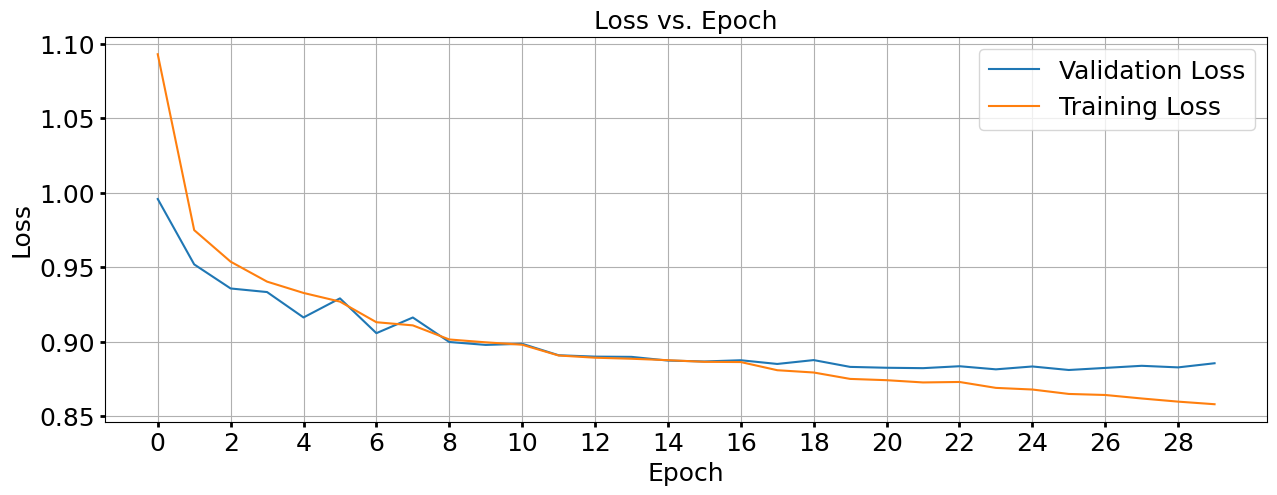

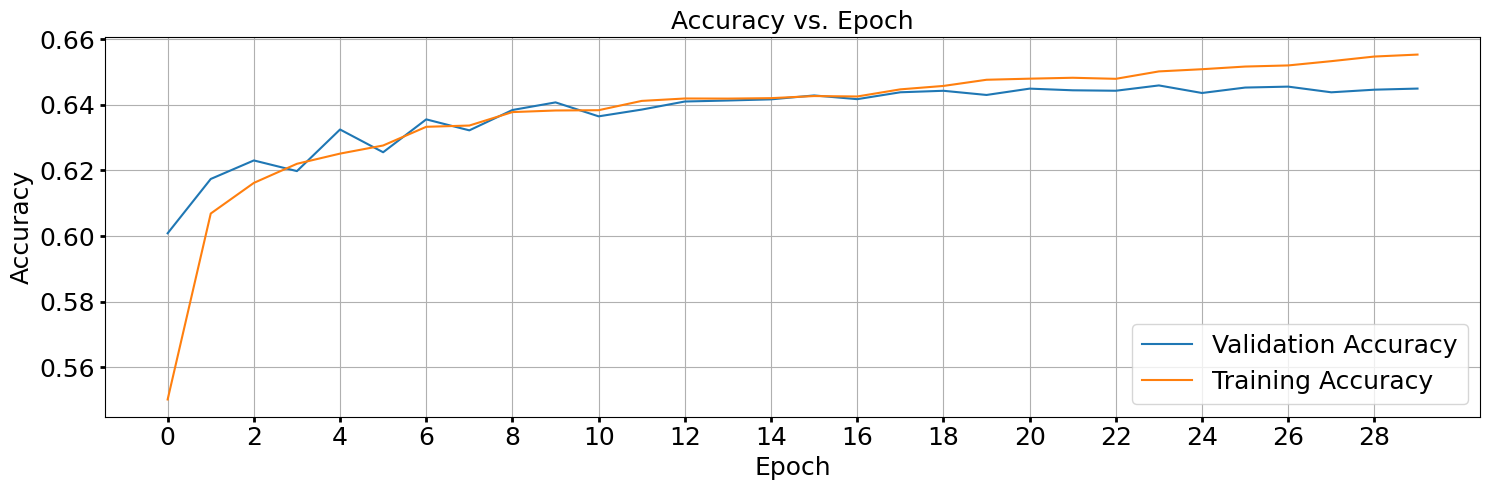

In [ ]:
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
import torch
from thop import profile
from thop import clever_format

import torchvision.models as models

from thop import profile

model = HSE()

# Define an example input with the desired shape
input_data = torch.randn(1, 1, 128, 2)  # Replace with your input shape

# Use thop.profile to profile the model
flops, params = profile(model, inputs=(input_data,))

# Format the FLOPs and parameters for better readability
flops, params = clever_format([flops, params], "%.3f")

print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import matplotlib.pyplot as plt

# checkpoint = "/content/drive/MyDrive/AMC/checkpoint/AMC_finetune_18.pth"
net = nn.DataParallel(HSE(num_classes=num_classes))
# net.load_state_dict(torch.load(checkpoint))
net.to(device)
net.eval()

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=2e-3, weight_decay = 5e-5)


best_accuracy = 0
best_loss = float('inf')
patience = 5
wait = 0

val_loss_average = []
accuracy_values_average = []
accuracy_train_average = []
training_loss =[]


for epoch in range(30):  # loop over the dataset multiple times
    print('learning rate', optimizer.param_groups[0]["lr"])
    net.train()
    overall_accuracy_total = 0
    train_loss = 0
    running_loss = 0.0
    val_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels_original = data
        inputs = inputs.to(device)
        labels = labels_original.to(device)
        inputs = torch.tensor(inputs, requires_grad=True)
        outputs = net(inputs)

        labels = torch.argmax(labels, dim=1)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss +=loss.item()

        if i == 0:
            pre_Y_train = outputs.detach().cpu().numpy()
            Y_train_snr_convert = labels_original.numpy()

        else:
            pre_Y_train = np.vstack((pre_Y_train, outputs.detach().cpu().numpy()))
            Y_train_snr_convert = np.vstack((Y_train_snr_convert, labels_original.numpy()))

        if i % 20 == 19:
            print(f'[{epoch+1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

    conf_train = np.zeros([len(classes), len(classes)])
    confnorm_train = np.zeros([len(classes), len(classes)])
    for i in range(0, pre_Y_train.shape[0]):
        j = list(Y_train_snr_convert[i, :]).index(1)
        k = int(np.argmax(pre_Y_train[i, :]))
        conf_train[j, k] = conf_train[j, k] + 1
    for i in range(0, len(classes)):
        confnorm_train[i, :] = conf_train[i, :] / np.sum(conf_train[i, :])

    cor_train = np.sum(np.diag(conf_train))
    ncor_train = np.sum(conf_train) - cor_train
    accuracy_train_average.append(cor_train / (cor_train + ncor_train))

    training_loss.append(train_loss / len(trainloader))

    net.eval()
    acc = {}
    Z_val = Z_val.reshape((len(Z_val)))
    SNRs = np.unique(Z_val)

    # Initialize empty lists to store loss and accuracy for each SNR
    loss_values = {snr: [] for snr in SNRs}
    accuracy_values = {snr: [] for snr in SNRs}

    for snr in SNRs:
        X_val_snr = X_val[Z_val == snr]
        Y_val_snr = Y_val[Z_val == snr]
        X_val_snr_tensor = torch.Tensor(X_val_snr)
        Y_val_snr_tensor = torch.Tensor(Y_val_snr).long()
        val_dataset = TensorDataset(X_val_snr_tensor, Y_val_snr_tensor)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        val_loss = 0

        for i, data in enumerate(valloader, 0):

                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                labels_loss = torch.argmax(labels, dim=1).long()
                loss = criterion(outputs, labels_loss)
                val_loss += loss.item()

                if i == 0:
                    pre_Y_val = outputs.detach().cpu().numpy()
                    Y_val_snr_convert = labels.detach().cpu().numpy()

                else:
                    pre_Y_val = np.vstack((pre_Y_val, outputs.detach().cpu().numpy()))
                    Y_val_snr_convert = np.vstack((Y_val_snr_convert, labels.detach().cpu().numpy()))

        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])
        for i in range(0, X_val_snr.shape[0]):
            j = list(Y_val_snr_convert[i, :]).index(1)
            k = int(np.argmax(pre_Y_val[i, :]))
            conf[j, k] = conf[j, k] + 1
        for i in range(0, len(classes)):
            confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        overall_accuracy = cor / (cor + ncor)
        print("Overall Accuracy %s: " % snr, cor / (cor + ncor))


        # Check if the current accuracy is the best
        if overall_accuracy > best_accuracy:
            best_accuracy = overall_accuracy  # Update the best accuracy
            best_epoch_accuracy = epoch+1  # Update the best epoch

        # Append loss and accuracy values to the corresponding SNR lists
        loss_values[snr].append(val_loss / len(valloader))
        accuracy_values[snr].append(overall_accuracy)

    # Compute the average loss and accuracy for this epoch
    average_loss = sum(loss_values[snr][-1] for snr in SNRs) / len(SNRs)
    average_accuracy = sum(accuracy_values[snr][-1] for snr in SNRs) / len(SNRs)
    print("Overall Accuracy Train", cor_train / (cor_train + ncor_train))
    print("Overall Accuracy Validation", average_loss, average_accuracy)

    val_loss_average.append(average_loss)
    accuracy_values_average.append(average_accuracy)

    if epoch % 1 == 0:
        print('predicted', torch.argmax(outputs, dim=1))
        print('labels', torch.argmax(labels, dim=1))
        print("val_loss: ", average_loss)
        print("best accuracy: " , best_accuracy)
        torch.save(net.state_dict(), '/content/drive/MyDrive/AMC/checkpoint/AMC_2016b_%d.pth' % (epoch))
        print('Epoch:%d Model Saved!' % (epoch + 1))
        if average_loss < best_loss:
            best_loss = average_loss
            print("best loss: ", best_loss)
            print("val_loss: ", val_loss_average)
            val_loss = 0.0
            wait = 0
            best_epoch = epoch+1
        else:
            val_loss = 0.0
            optimizer.param_groups[0]["lr"] = optimizer.param_groups[0]["lr"] * 0.7
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss. Best epoch is {best_epoch}')
                break

print("Best overall accuracy was achieved at epoch", best_epoch_accuracy)
print("best accuracy: " , best_accuracy)
print('Finished Training')

# Increase the font size for axis labels
font_size = 18

# Increase the thickness of tick lines
tick_size = 2

# Create the first figure for loss
plt.figure(figsize=(15, 5))

plt.plot(val_loss_average, label='Validation Loss')
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch', fontsize=font_size)
plt.ylabel('Loss', fontsize=font_size)
plt.title('Loss vs. Epoch', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.grid(True)

# Customize x-tick positions and increase tick label size
epochs = len(val_loss_average)
x_tick_positions = list(range(0, epochs, 2))
plt.xticks(x_tick_positions, fontsize=font_size)
plt.yticks(fontsize=font_size)

# Set the thickness of tick lines
plt.gca().xaxis.set_tick_params(width=tick_size)
plt.gca().yaxis.set_tick_params(width=tick_size)

# Create the second figure for accuracy
plt.figure(figsize=(15, 5))

plt.plot(accuracy_values_average, label='Validation Accuracy')
plt.plot(accuracy_train_average, label='Training Accuracy')
plt.xlabel('Epoch', fontsize=font_size)
plt.ylabel('Accuracy', fontsize=font_size)
plt.title('Accuracy vs. Epoch', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.grid(True)

# Customize x-tick positions and increase tick label size
plt.xticks(x_tick_positions, fontsize=font_size)
plt.yticks(fontsize=font_size)

# Set the thickness of tick lines
plt.gca().xaxis.set_tick_params(width=tick_size)
plt.gca().yaxis.set_tick_params(width=tick_size)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

checkpoint = "/content/drive/MyDrive/AMC/checkpoint/AMC_2016b_25.pth"
net = nn.DataParallel(HSE(num_classes=num_classes))
net.to(device)
net.load_state_dict(torch.load(checkpoint))

net.eval()

# Initialize empty lists to store loss and accuracy for each SNR
# loss_values = {snr: [] for snr in SNRs}
# accuracy_values = {snr: [] for snr in SNRs}

net.eval()
acc = {}
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)

for snr in SNRs:
    X_test_snr = X_test[Z_test == snr]
    Y_test_snr = Y_test[Z_test == snr]
    X_test_snr_tensor = torch.Tensor(X_test_snr)
    Y_test_snr_tensor = torch.Tensor(Y_test_snr).long()
    test_dataset = TensorDataset(X_test_snr_tensor, Y_test_snr_tensor)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    val_loss = 0

    for i, data in enumerate(testloader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            # labels_loss = torch.argmax(labels, dim=1).long()
            # loss = criterion(outputs, labels_loss)
            # val_loss += loss.item()

            if i == 0:
                pre_Y_test = outputs.detach().cpu().numpy()
                Y_test_snr_convert = labels.detach().cpu().numpy()

            else:
                pre_Y_test = np.vstack((pre_Y_test, outputs.detach().cpu().numpy()))
                Y_test_snr_convert = np.vstack((Y_test_snr_convert, labels.detach().cpu().numpy()))

    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, X_test_snr.shape[0]):
        j = list(Y_test_snr_convert[i, :]).index(1)
        k = int(np.argmax(pre_Y_test[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    overall_accuracy = cor / (cor + ncor)
    print("Overall Accuracy %s: " % snr, cor / (cor + ncor))



Overall Accuracy -20:  0.10683713173985547
Overall Accuracy -18:  0.11454239191465469
Overall Accuracy -16:  0.1229654403567447
Overall Accuracy -14:  0.15804025658040258
Overall Accuracy -12:  0.20883757077828355
Overall Accuracy -10:  0.3105817174515235
Overall Accuracy -8:  0.4256764280146977
Overall Accuracy -6:  0.5530720105703589
Overall Accuracy -4:  0.7234537796497451
Overall Accuracy -2:  0.8530259365994236
Overall Accuracy 0:  0.905503867279453
Overall Accuracy 2:  0.9297543625652995
Overall Accuracy 4:  0.9304309294339205
Overall Accuracy 6:  0.9338713292983636
Overall Accuracy 8:  0.9369850812736584
Overall Accuracy 10:  0.9380794701986755
Overall Accuracy 12:  0.9400156968269986
Overall Accuracy 14:  0.940188762071993
Overall Accuracy 16:  0.9442366915970084
Overall Accuracy 18:  0.939777952226085


In [ ]:
print("Validation Loss", val_loss_average)
print("Training Loss", training_loss)

print("Testing Accuracy", accuracy_values_average)
print("Training Accuracy", accuracy_train_average)

Validation Loss [0.9956749466948567, 0.9517960215209141, 0.9356384723958755, 0.9332318659715118, 0.9161932350940528, 0.9289966578639687, 0.9056474596211717, 0.9161669928389824, 0.899727594036136, 0.8977692585021613, 0.8985264715611466, 0.8908333342445515, 0.8899090758039956, 0.8897506217550607, 0.8872596744953525, 0.8866584150255143, 0.8874845594371713, 0.8849897777892295, 0.8875856887386548, 0.8830186418885926, 0.8824385693636796, 0.8821701232377913, 0.883462945039251, 0.88138091229671, 0.8833010054160914, 0.880938145351848, 0.8823389254441288, 0.8837520873777214, 0.882689738734847, 0.8854670237523639]
Training Loss [1.0928187229188748, 0.9747923883376217, 0.9536162586672723, 0.9402336147883402, 0.9326434673731244, 0.9268294774599732, 0.9129928760344048, 0.910879238268575, 0.90141960707908, 0.8995035821929492, 0.89788318223375, 0.8906618834159347, 0.8891806640979504, 0.8884850008541458, 0.8875248285781168, 0.8864226507239775, 0.8862638483862554, 0.8807927165759329, 0.8792572063618067,

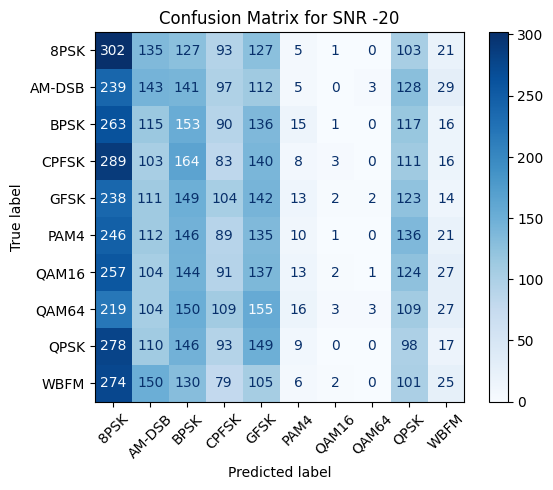

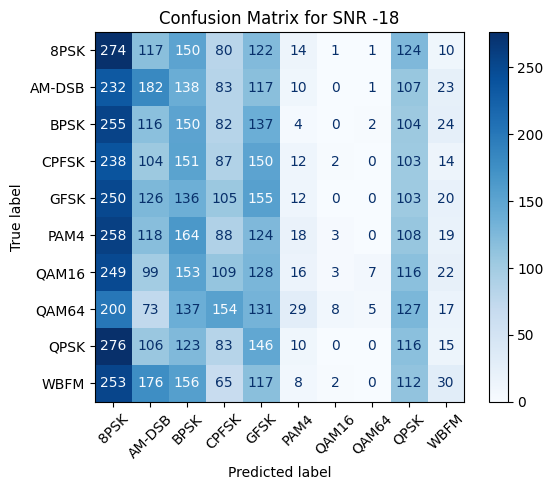

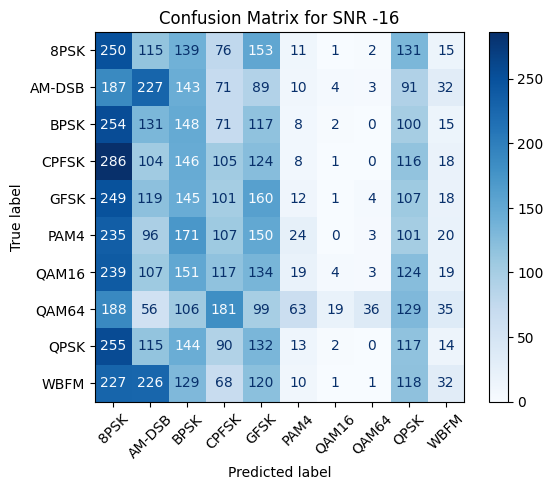

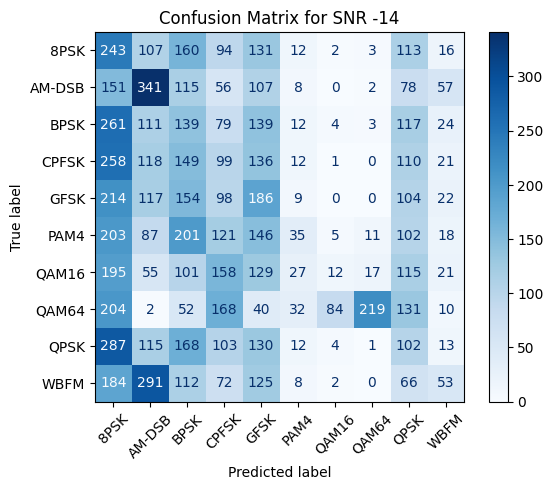

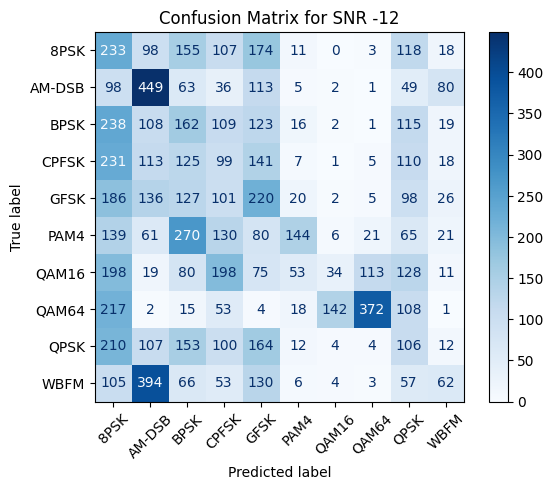

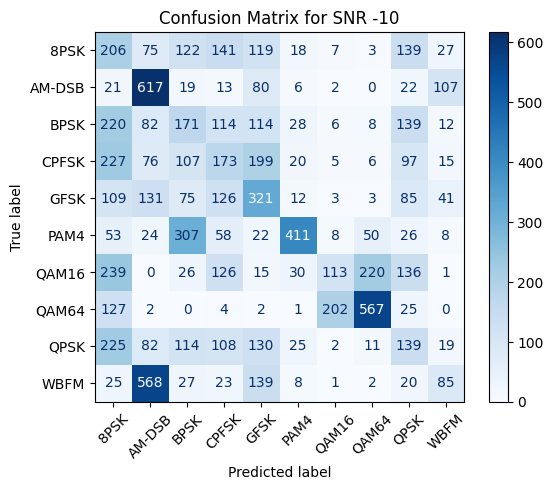

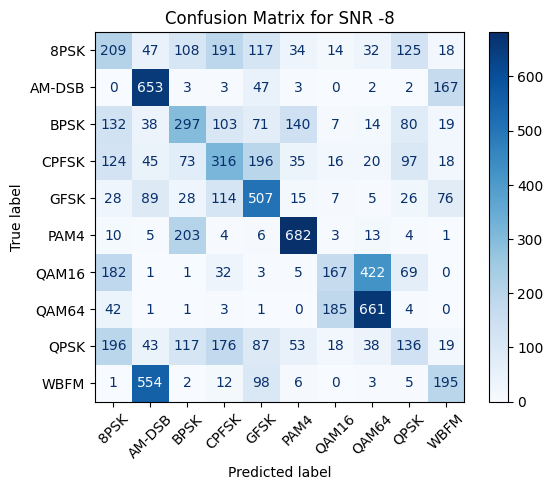

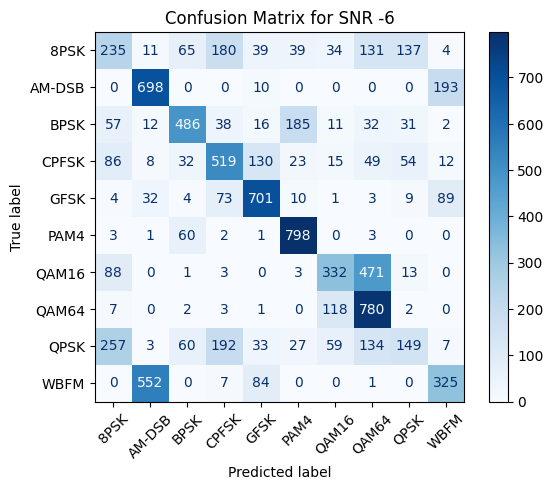

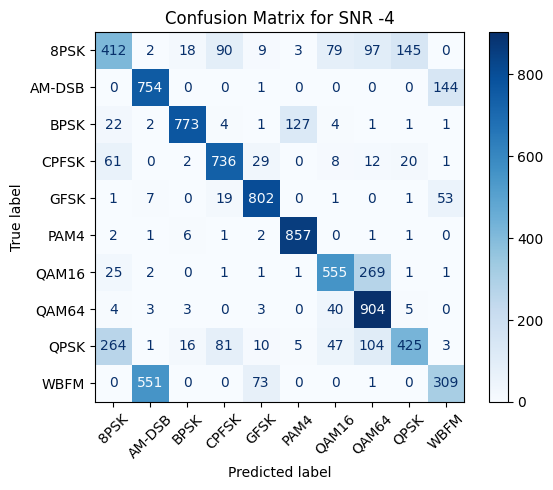

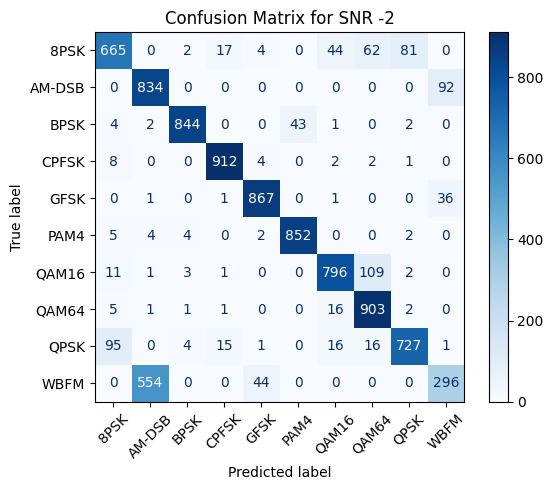

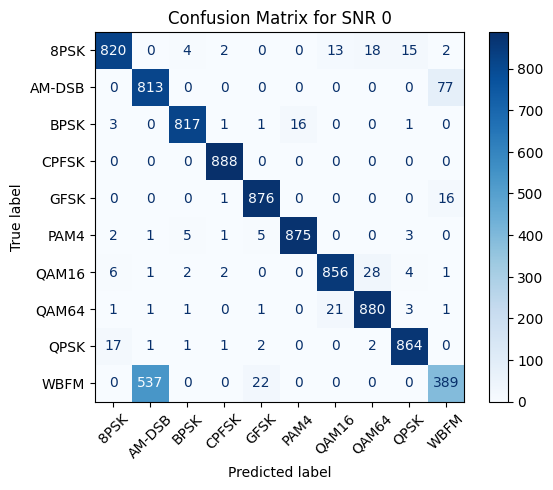

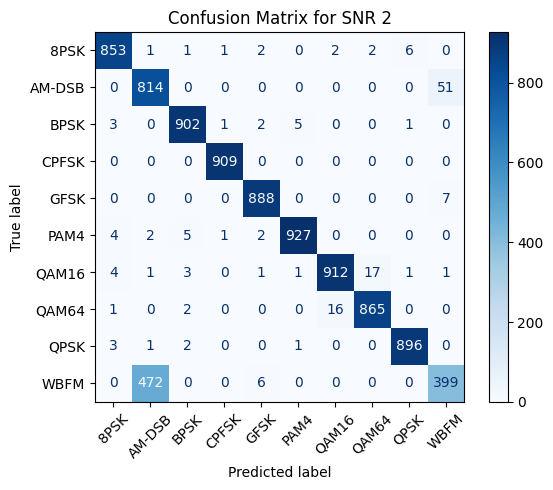

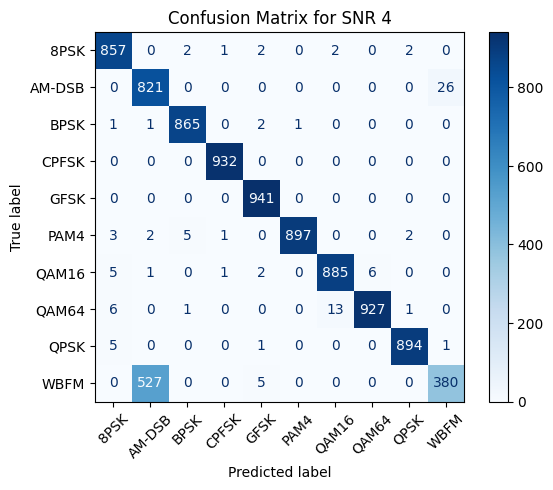

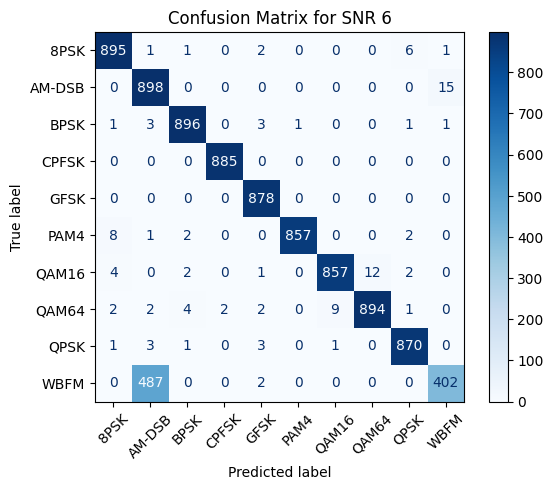

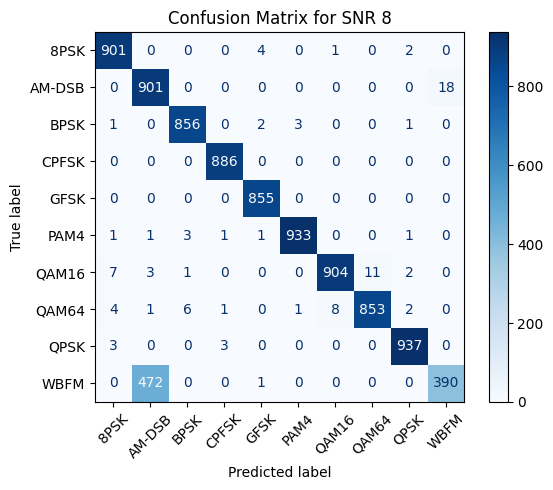

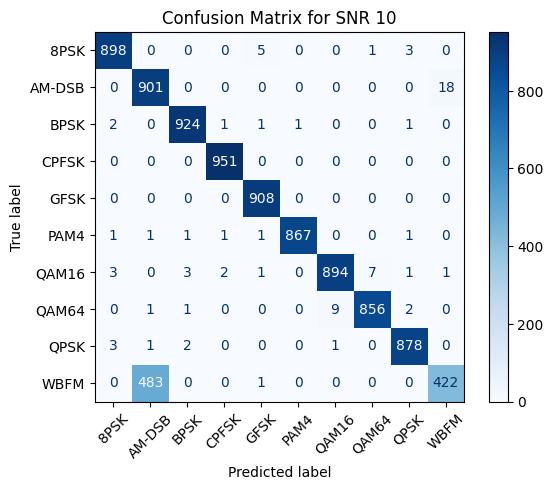

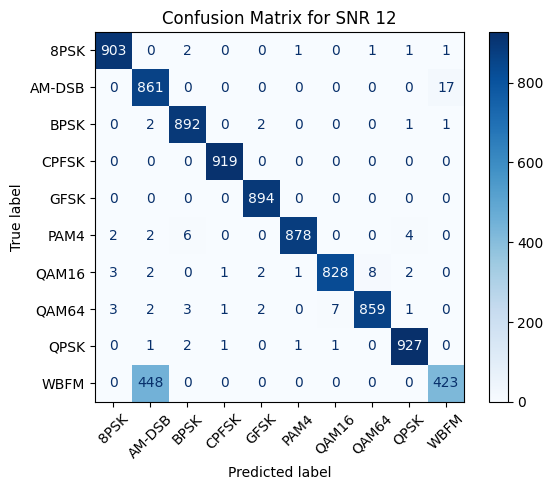

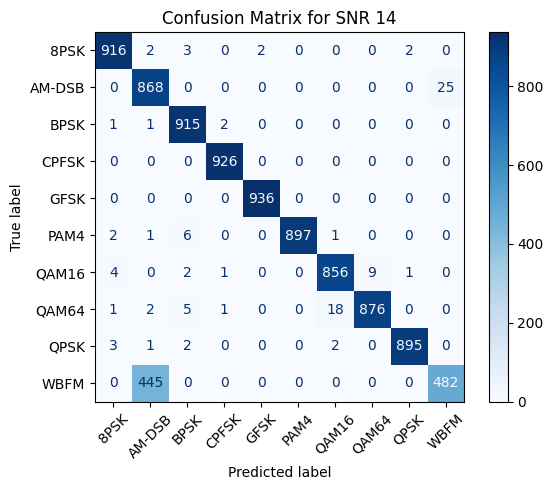

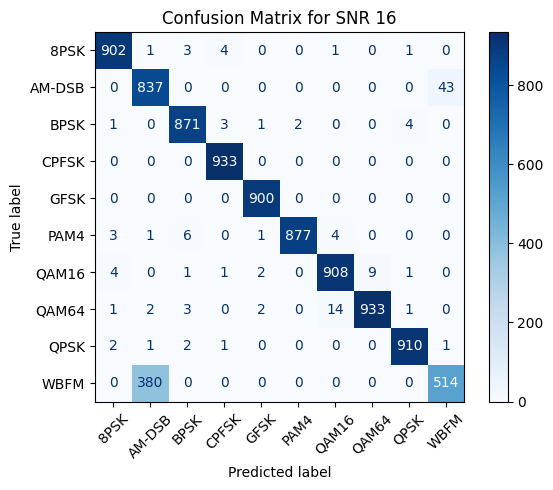

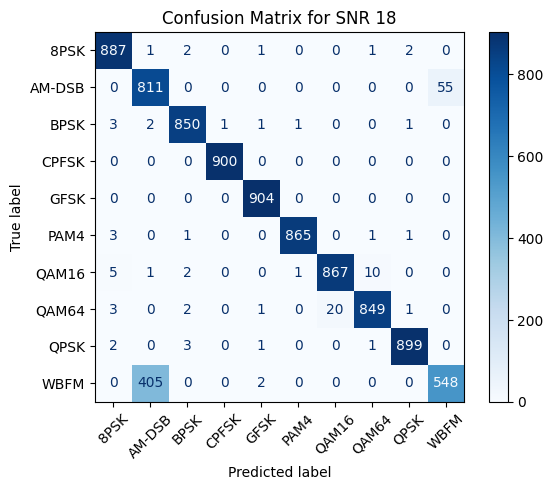

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

checkpoint = "/content/drive/MyDrive/AMC/checkpoint/AMC_2016b_25.pth"
net = nn.DataParallel(HSE(num_classes=num_classes))
net.to(device)
net.load_state_dict(torch.load(checkpoint))

net.eval()

confusion_matrices = []
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    # Load data for the current SNR
    X_test_snr = X_test[Z_test == snr]
    Y_test_snr = Y_test[Z_test == snr]
    X_test_snr_tensor = torch.Tensor(X_test_snr)
    Y_test_snr_tensor = torch.Tensor(Y_test_snr).long()
    test_dataset = TensorDataset(X_test_snr_tensor, Y_test_snr_tensor)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Define lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Make predictions on the test dataset
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            true_labels.extend(labels.argmax(dim=1).numpy())
            predicted_labels.extend(outputs.detach().cpu().argmax(dim=1).numpy())

    # Compute the confusion matrix for the current SNR
    confusion = confusion_matrix(true_labels, predicted_labels)
    confusion_matrices.append(confusion)

# Plot the confusion matrices for each SNR
for i, snr in enumerate(SNRs):
    disp = ConfusionMatrixDisplay(confusion_matrices[i], display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix for SNR {snr}')
    plt.xticks(rotation=45)
    plt.show()

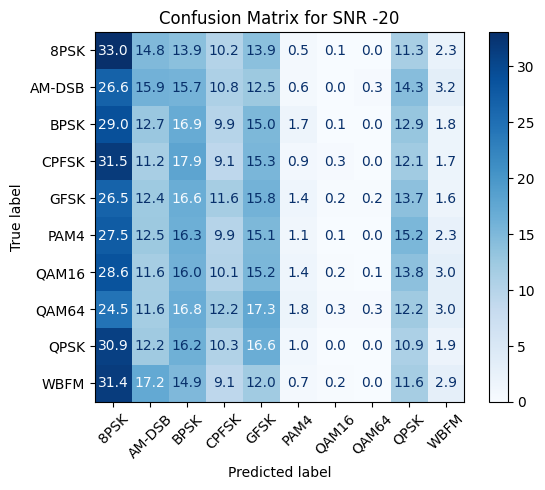

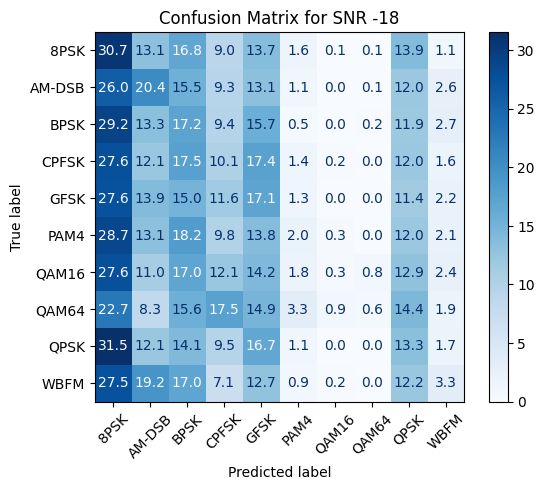

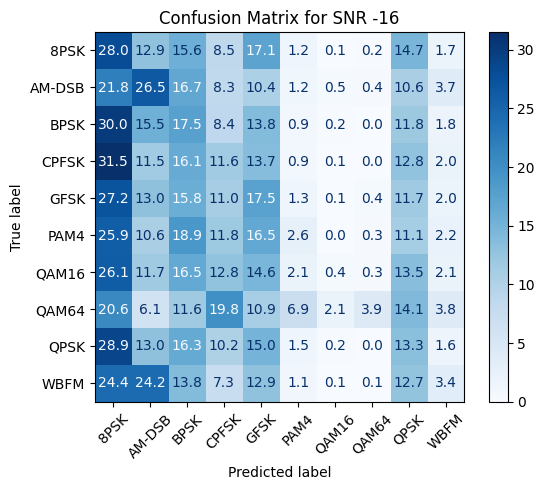

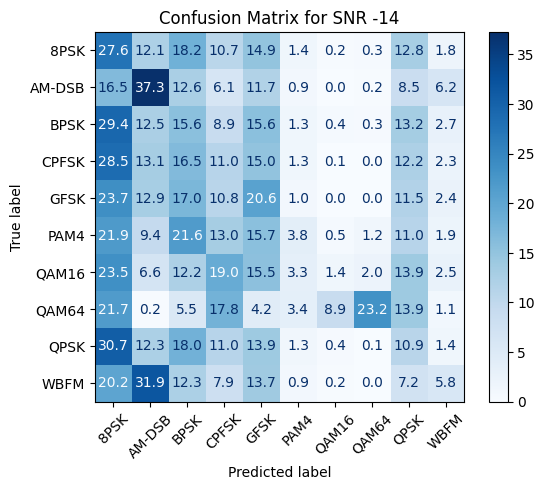

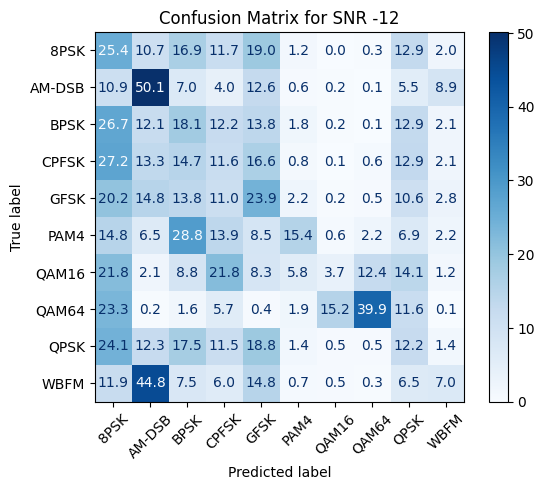

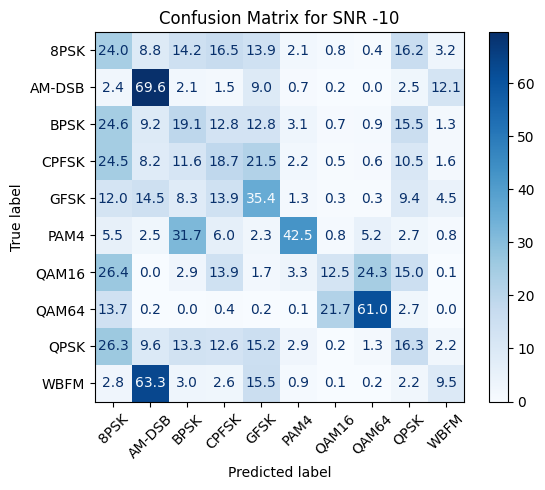

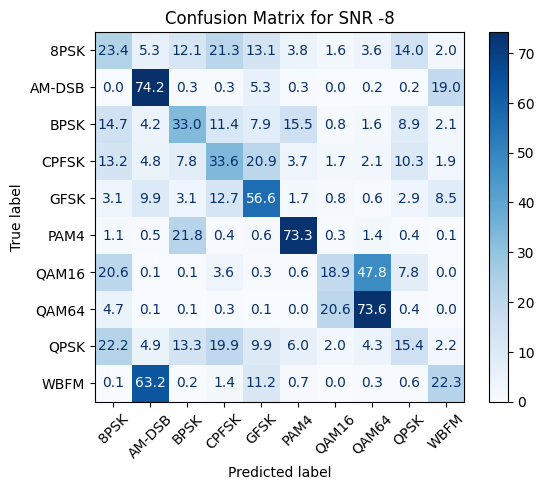

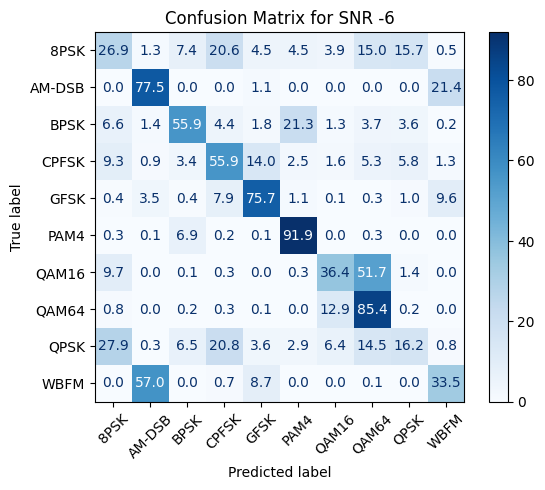

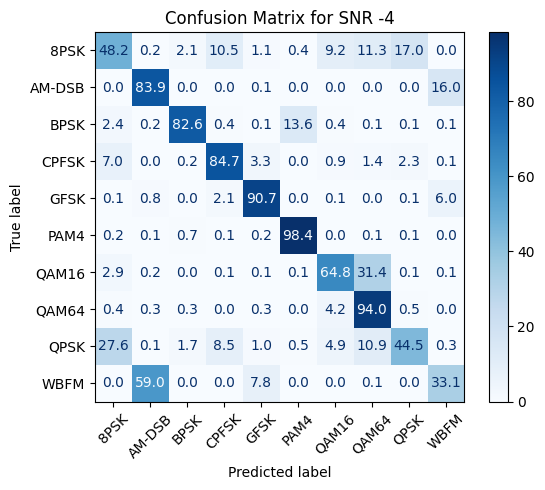

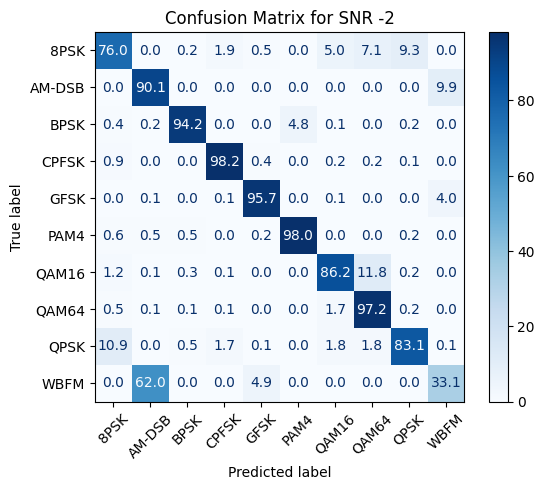

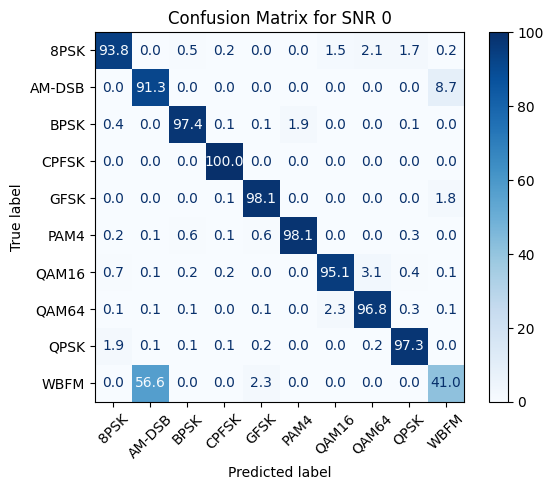

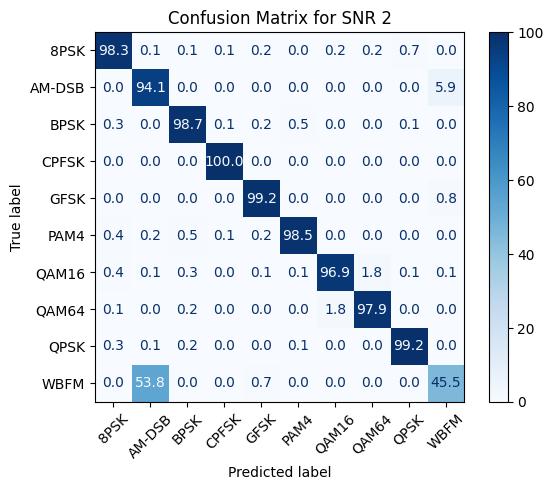

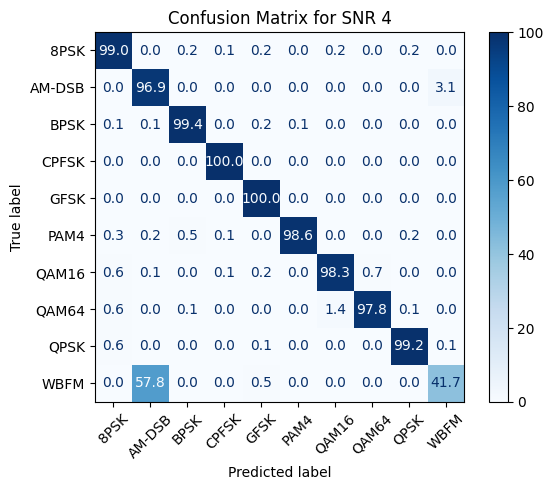

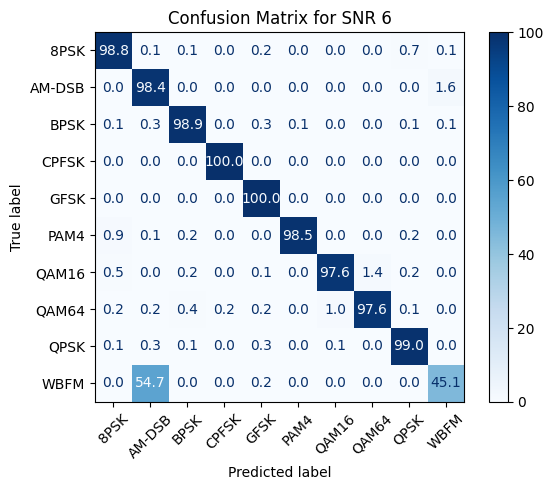

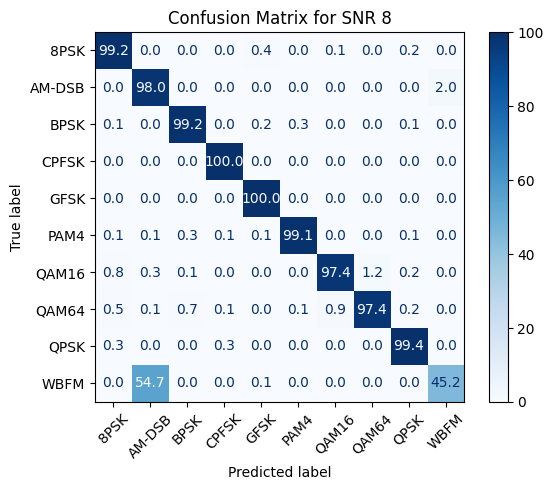

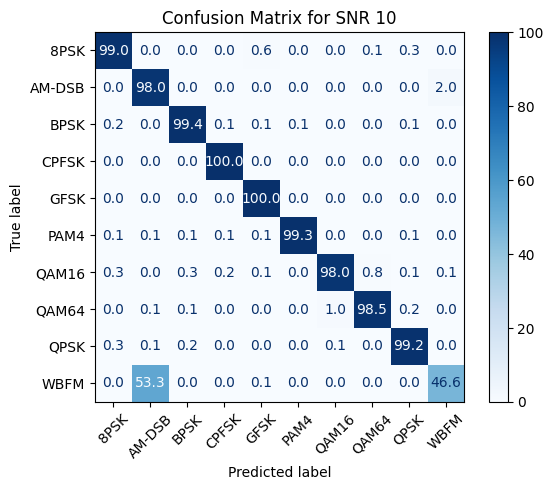

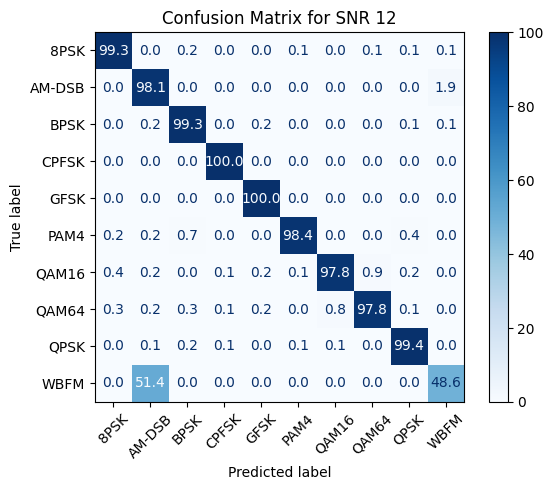

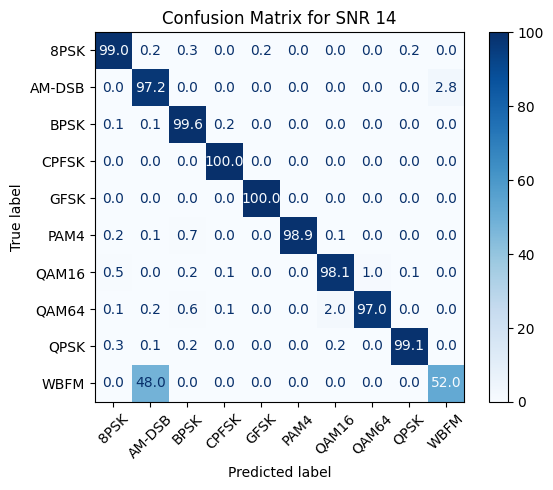

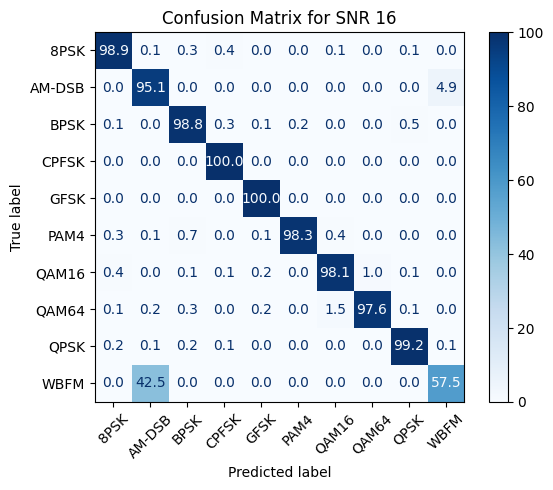

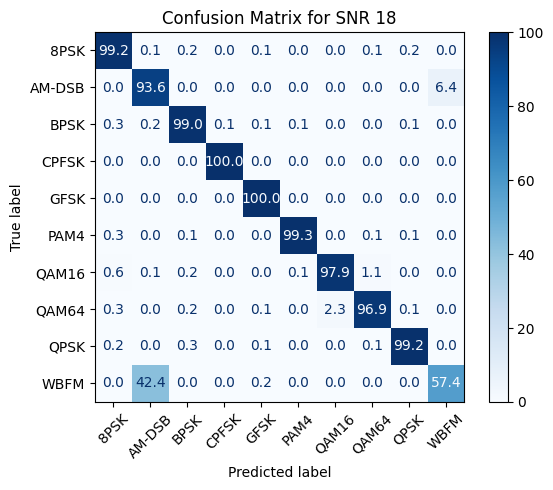

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

checkpoint = "/content/drive/MyDrive/AMC/checkpoint/AMC_2016b_25.pth"
net = nn.DataParallel(HSE(num_classes=num_classes))
net.to(device)
net.load_state_dict(torch.load(checkpoint))

net.eval()

confusion_matrices = []
SNRs = np.unique(Z_test)
for snr in SNRs:
    # Load data for the current SNR
    X_test_snr = X_test[Z_test == snr]
    Y_test_snr = Y_test[Z_test == snr]
    X_test_snr_tensor = torch.Tensor(X_test_snr)
    Y_test_snr_tensor = torch.Tensor(Y_test_snr).long()
    test_dataset = TensorDataset(X_test_snr_tensor, Y_test_snr_tensor)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Define lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Make predictions on the test dataset
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            true_labels.extend(labels.argmax(dim=1).numpy())
            predicted_labels.extend(outputs.detach().cpu().argmax(dim=1).numpy())

    # Compute the confusion matrix for the current SNR
    confusion = confusion_matrix(true_labels, predicted_labels)
    confusion_matrices.append(confusion)

# Plot the confusion matrices for each SNR
for i, snr in enumerate(SNRs):
    confusion_matrix_percentage = confusion_matrices[i] / confusion_matrices[i].sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix_percentage, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".1f")
    plt.title(f"Confusion Matrix for SNR {snr}")
    plt.xticks(rotation=45)
    plt.show()


Accuracy: 10.68%


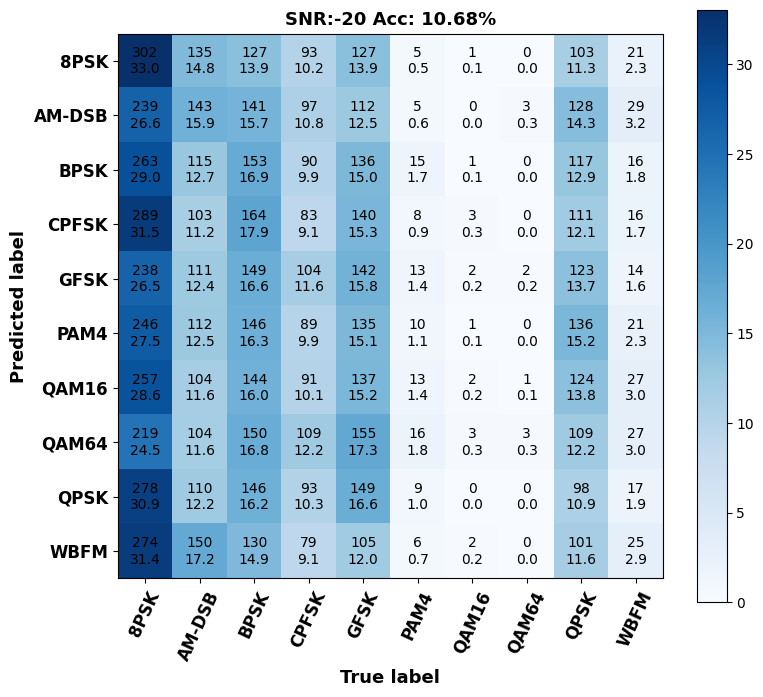

Accuracy: 11.45%


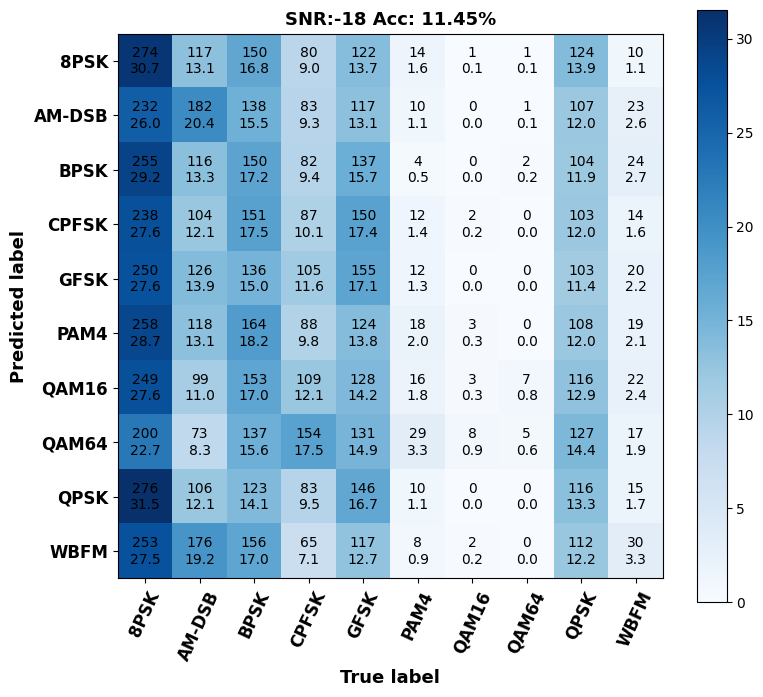

Accuracy: 12.30%


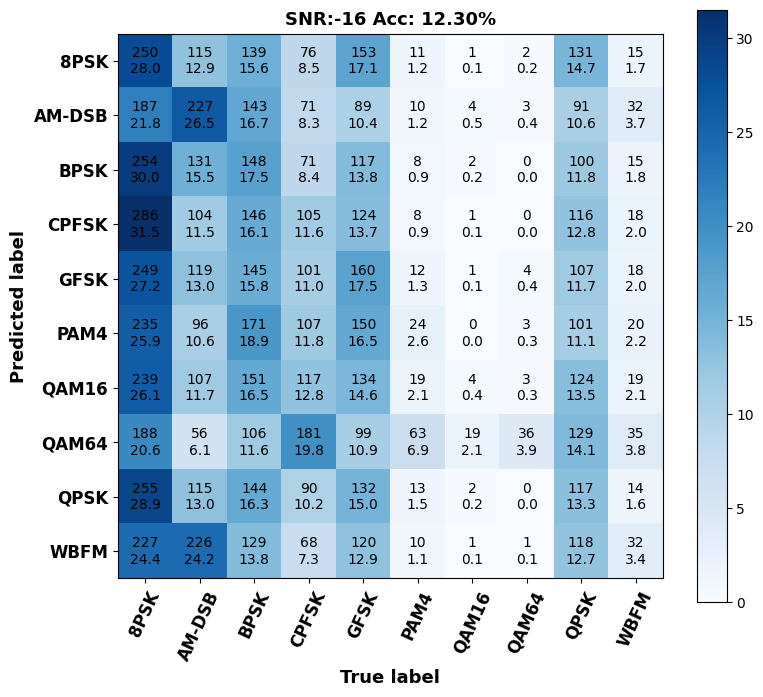

Accuracy: 15.80%


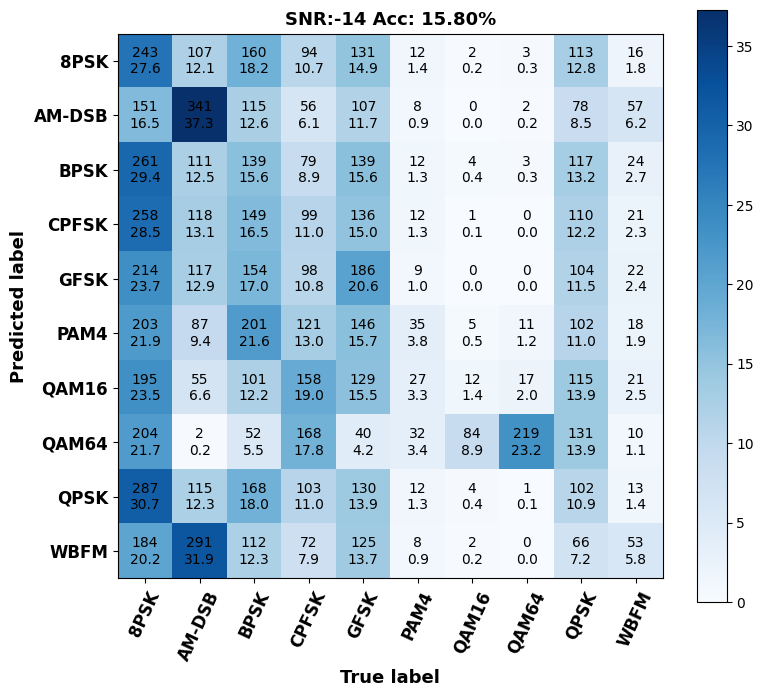

Accuracy: 20.88%


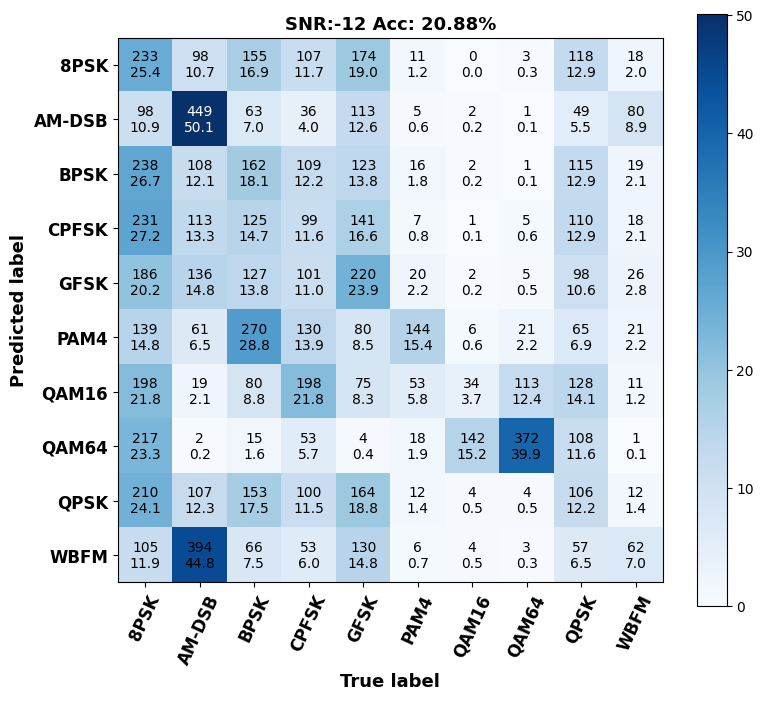

Accuracy: 31.06%


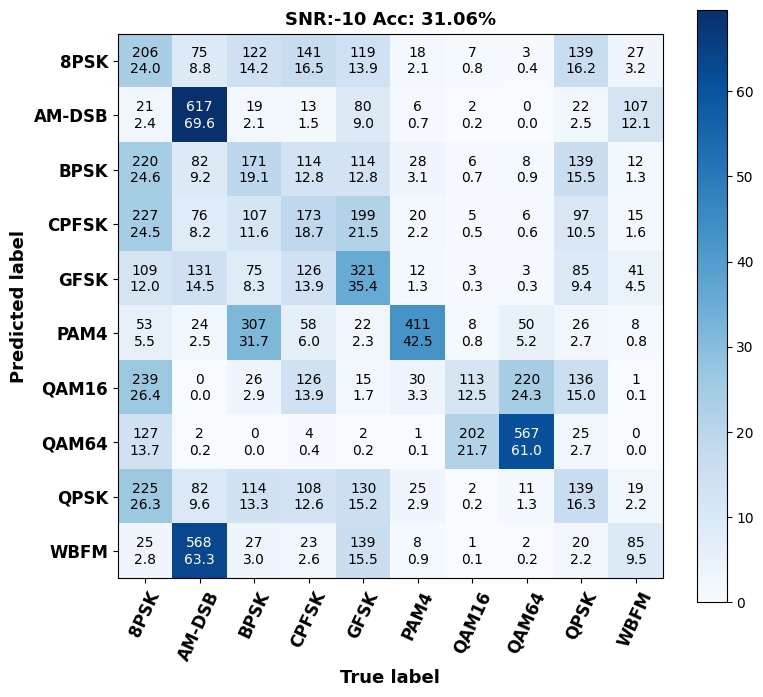

Accuracy: 42.57%


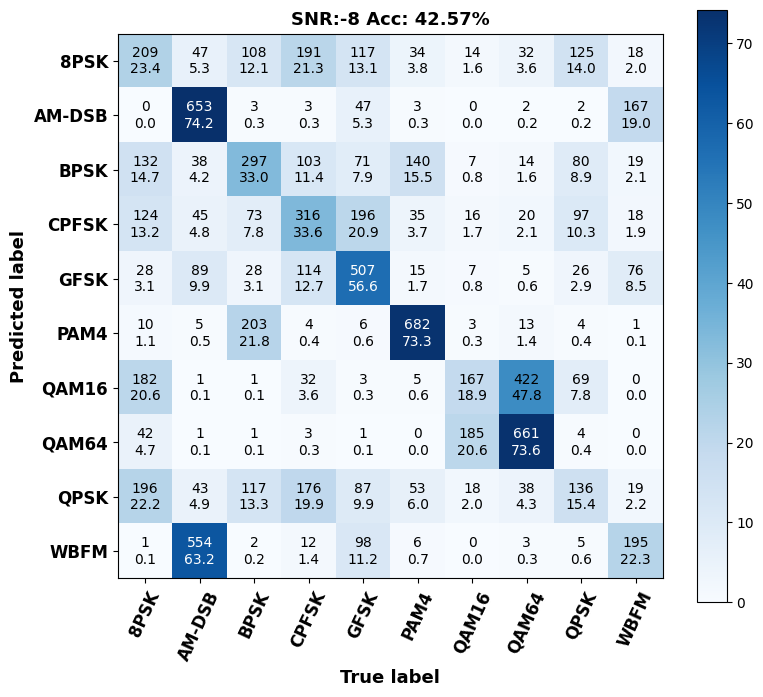

Accuracy: 55.31%


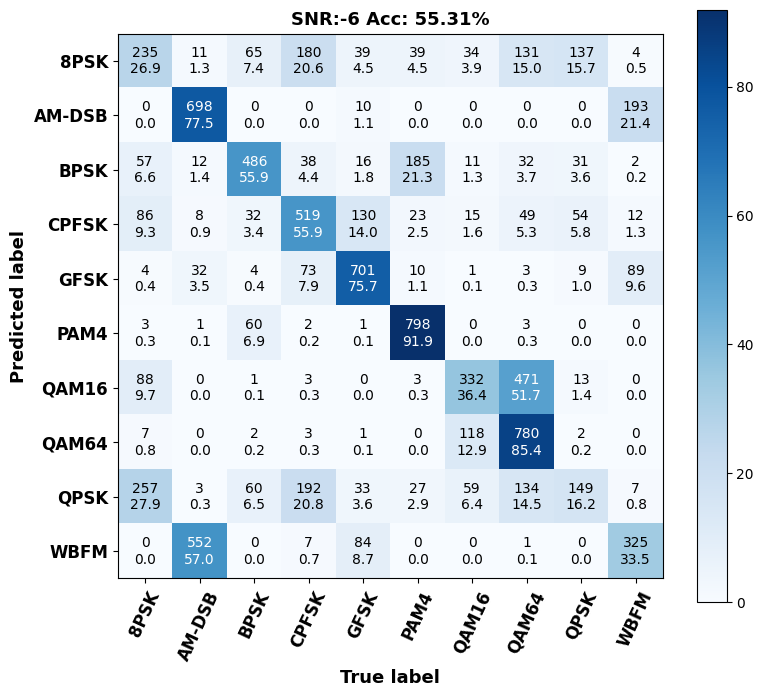

Accuracy: 72.35%


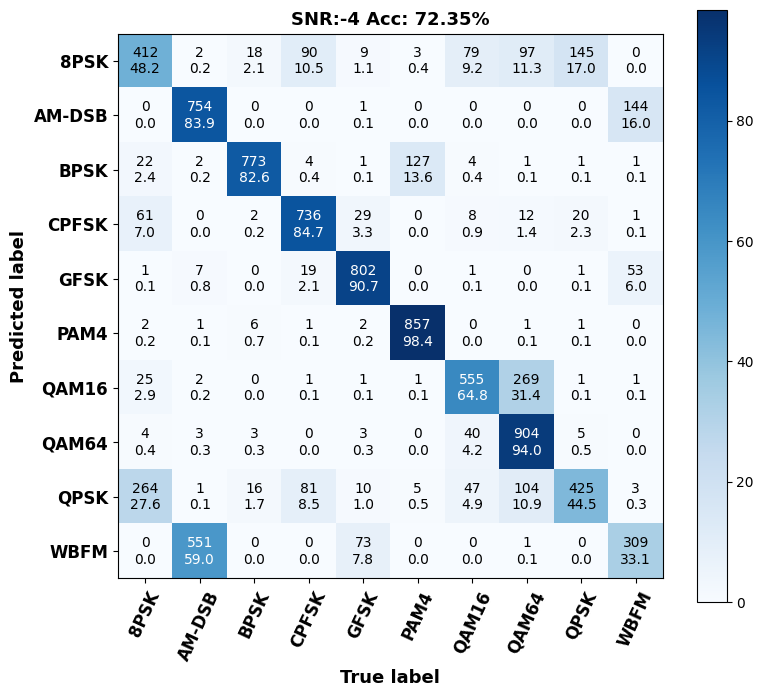

Accuracy: 85.30%


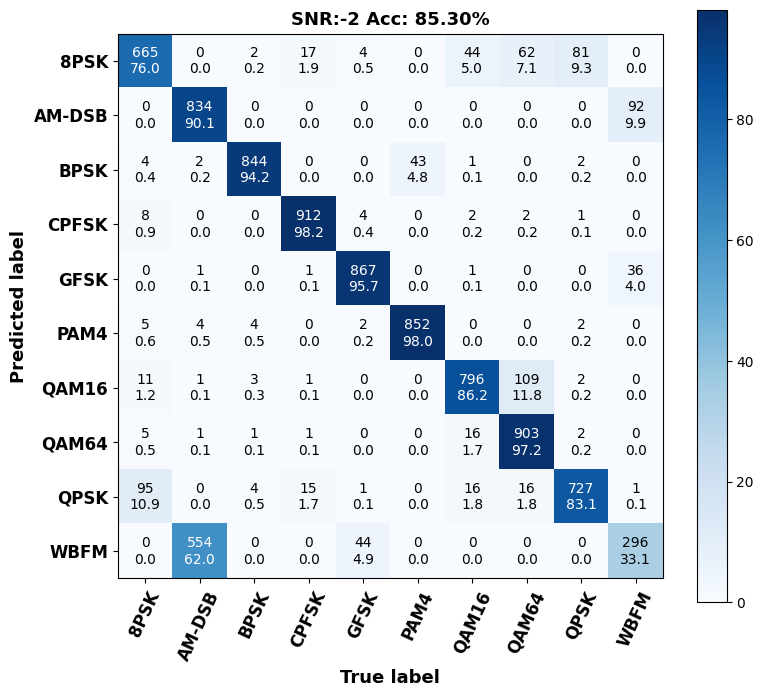

Accuracy: 90.55%


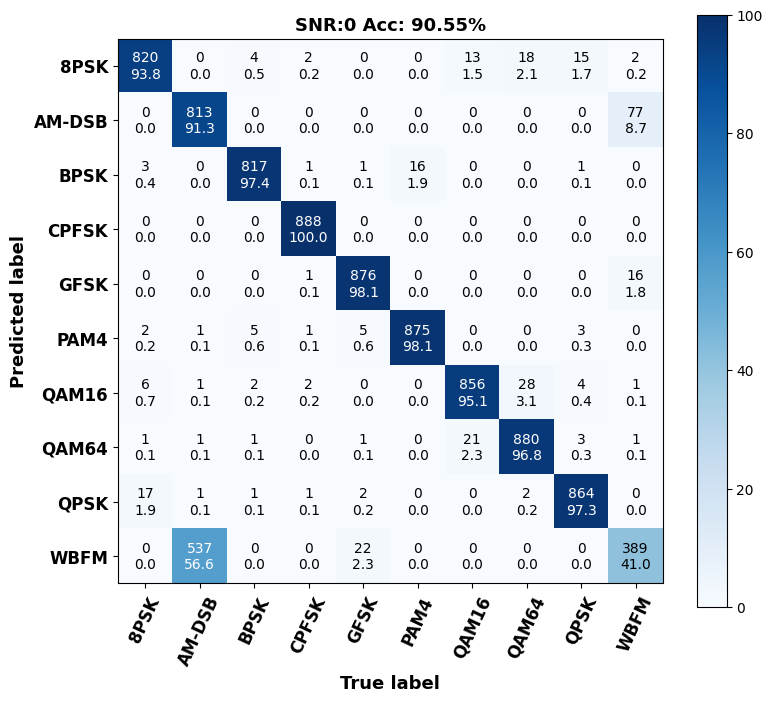

Accuracy: 92.98%


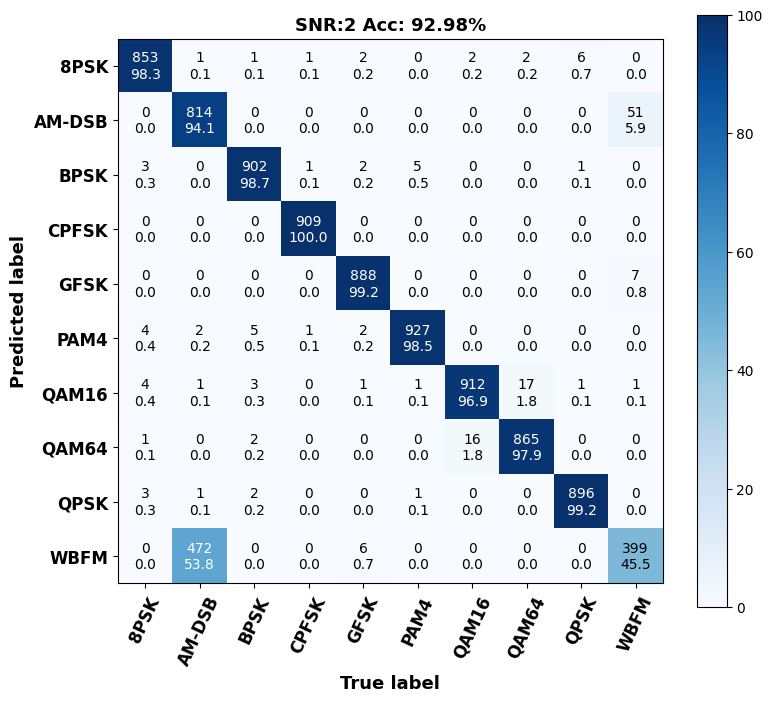

Accuracy: 93.04%


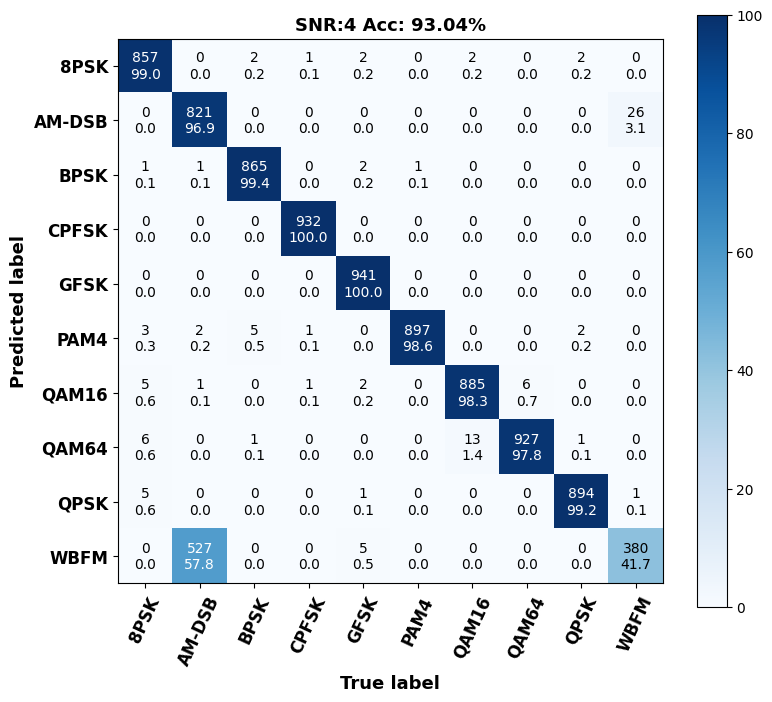

Accuracy: 93.39%


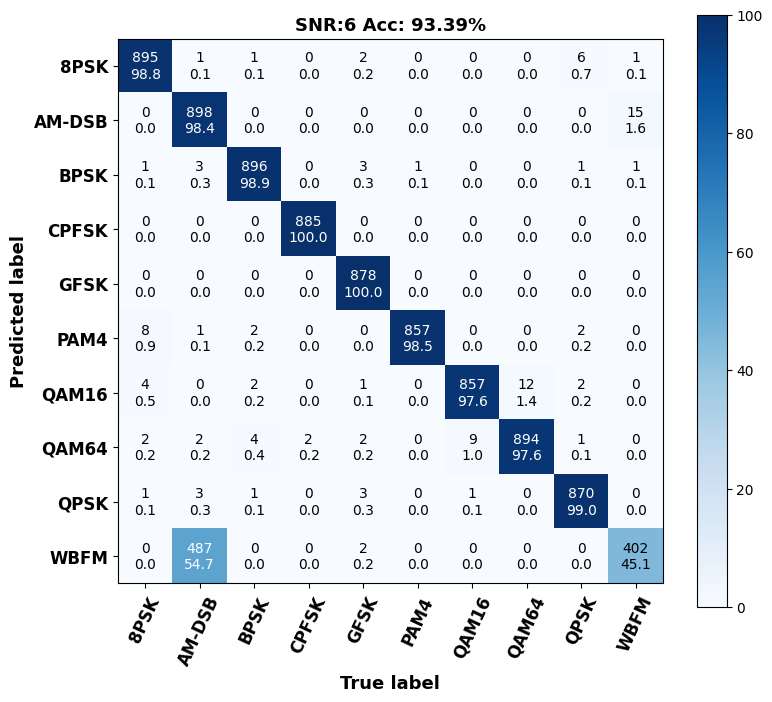

Accuracy: 93.70%


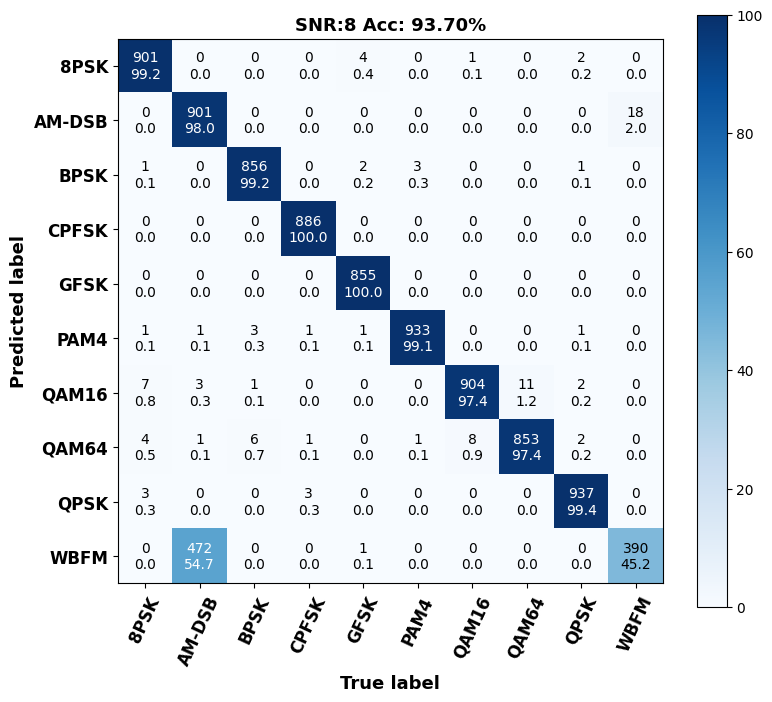

Accuracy: 93.81%


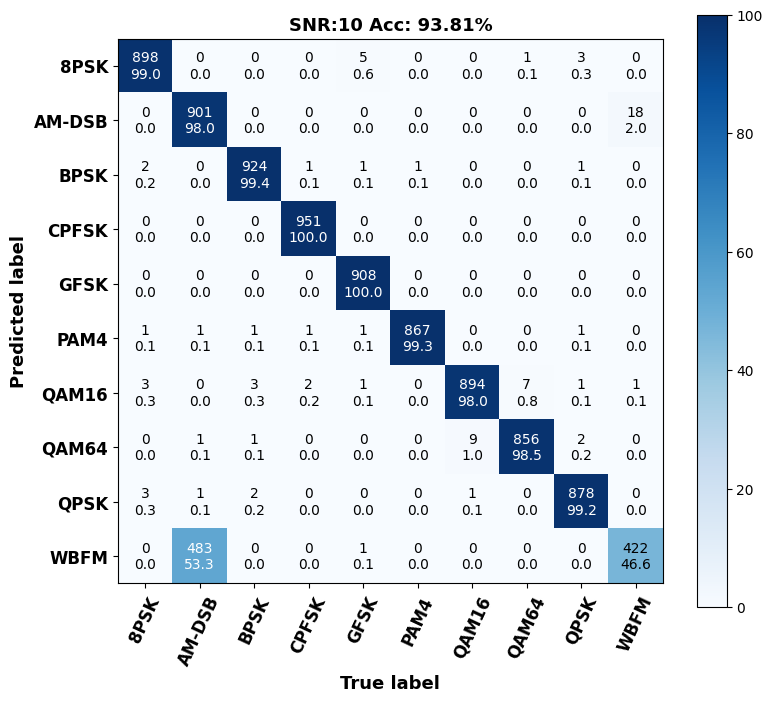

Accuracy: 94.00%


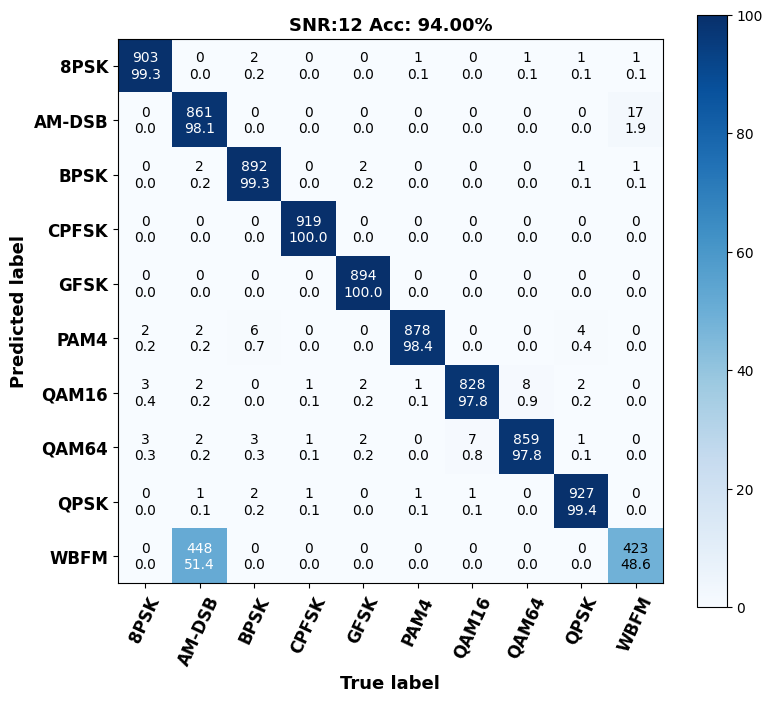

Accuracy: 94.02%


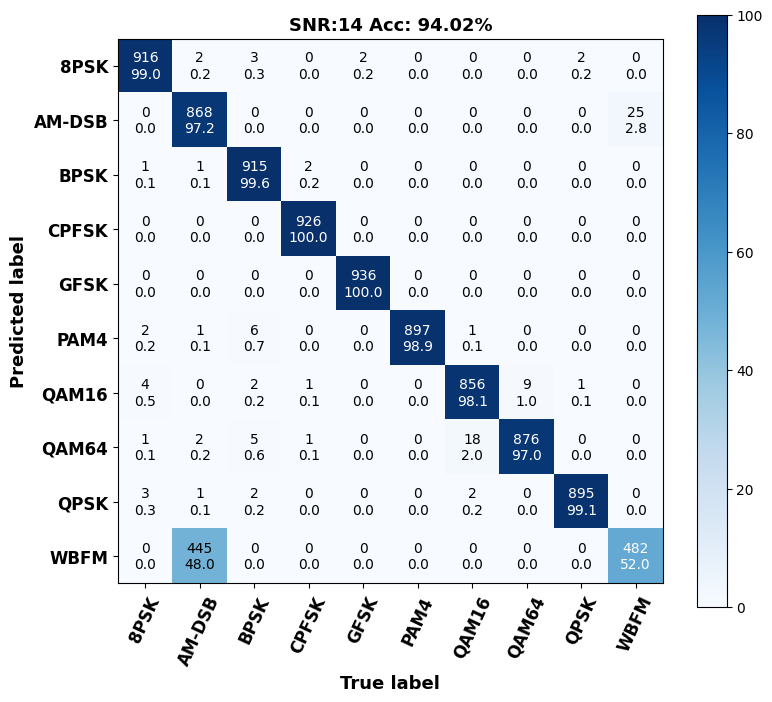

Accuracy: 94.42%


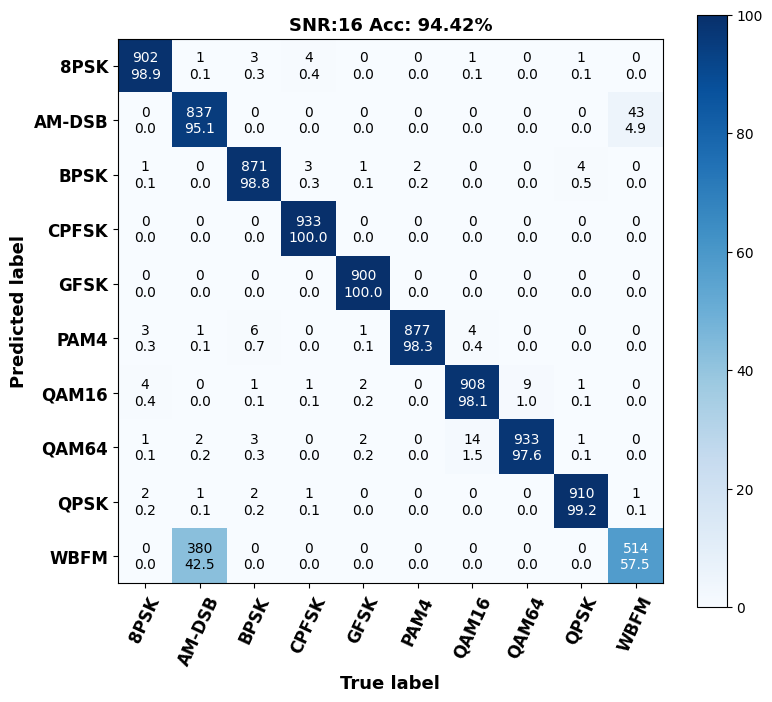

Accuracy: 93.98%


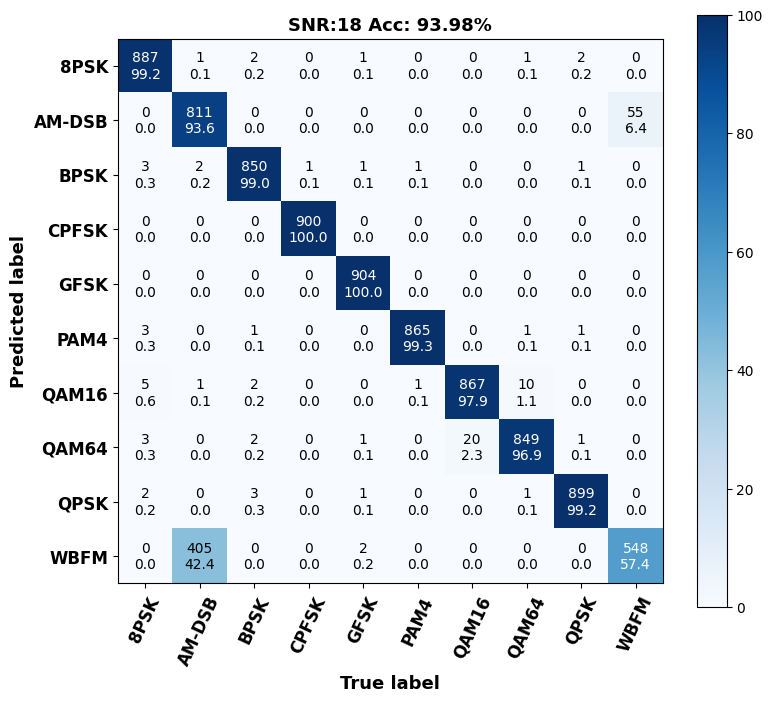

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, snr, title='SNR', cmap=plt.cm.Blues, labels=[]):
    y_true_labels, y_pred_labels = y_true, y_pred
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Calculate percentage values for the confusion matrix
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = cm_percent * 100

    plt.figure(figsize=(8, 8))
    an_image = plt.imshow(cm_percent, interpolation='nearest', cmap=cmap)
    for (y, x), value in np.ndenumerate(cm):
        percent = cm_percent[y, x]
        plt.text(x, y, f"{value}\n{percent:.1f}", va="center", ha="center", fontsize=10, color=('black' if percent < 50 else 'white'))

    plt.title(f"{title}:{snr} Acc: {accuracy * 100:.2f}%", fontsize=13, weight='bold')
    plt.colorbar(an_image, shrink=0.8)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=65)
    plt.yticks(tick_marks, labels)
    plt.ylabel('Predicted label', fontsize=13, weight='bold')
    plt.xlabel('True label', fontsize=13, weight='bold')
    plt.tight_layout()
    plt.savefig("squares{}.png".format(snr))
    plt.xticks( fontsize=12, weight='bold')
    plt.yticks( fontsize=12, weight='bold')
    plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

checkpoint = "/content/drive/MyDrive/AMC/checkpoint/AMC_2016b_25.pth"
net = nn.DataParallel(HSE(num_classes=num_classes))
net.to(device)
net.load_state_dict(torch.load(checkpoint))

net.eval()

confusion_matrices = []
SNRs = np.unique(Z_test)
for snr in snrs:
    # Load data for the current SNR
    X_test_snr = X_test[Z_test.squeeze() == snr]
    Y_test_snr = Y_test[Z_test.squeeze() == snr]
    X_test_snr_tensor = torch.Tensor(X_test_snr)
    Y_test_snr_tensor = torch.Tensor(Y_test_snr).long()
    test_dataset = TensorDataset(X_test_snr_tensor, Y_test_snr_tensor)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Define lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Make predictions on the test dataset
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            true_labels.extend(labels.argmax(dim=1).numpy())
            predicted_labels.extend(outputs.detach().cpu().argmax(dim=1).numpy())

    # Compute the confusion matrix for the current SNR
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Compute the confusion matrix for the current SNR
    confusion = confusion_matrix(true_labels, predicted_labels)
    plot_confusion_matrix(y_true = true_labels, y_pred= predicted_labels, snr=snr, labels= classes)




cuda


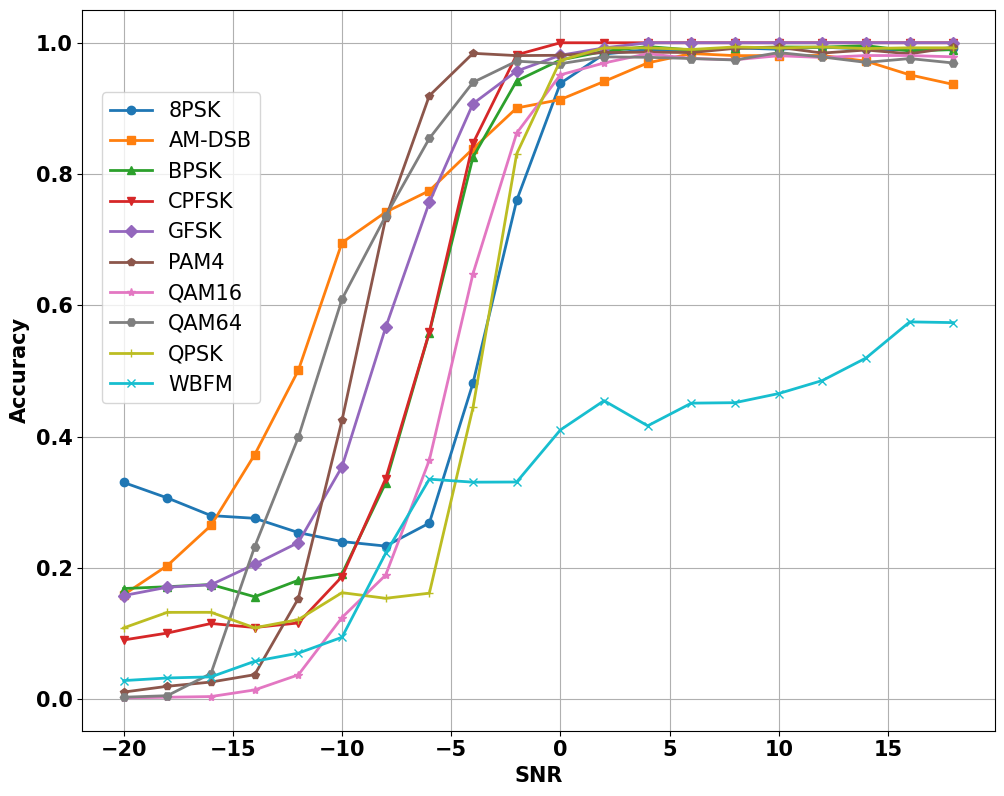

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

checkpoint = "/content/drive/MyDrive/AMC/checkpoint/AMC_2016b_25.pth"
net = nn.DataParallel(HSE(num_classes=num_classes))
net.to(device)
net.load_state_dict(torch.load(checkpoint))

net.eval()
snr_levels = sorted(np.unique(Z_test))
class_acc = {}

SNRs = np.unique(Z_test)
for snr in SNRs:
    # Load data for the current SNR
    X_test_snr = X_test[Z_test.squeeze() == snr]
    Y_test_snr = Y_test[Z_test.squeeze() == snr]
    X_test_snr_tensor = torch.Tensor(X_test_snr)
    Y_test_snr_tensor = torch.Tensor(Y_test_snr).long()
    test_dataset = TensorDataset(X_test_snr_tensor, Y_test_snr_tensor)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Define lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Make predictions on the test dataset
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            true_labels.extend(labels.argmax(dim=1).numpy())
            predicted_labels.extend(outputs.detach().cpu().argmax(dim=1).numpy())

    # Compute the confusion matrix for the current SNR
    conf = confusion_matrix(true_labels, predicted_labels)
    total_samples = np.sum(conf, axis=1)
    correct_samples = np.diagonal(conf)

    for idx, modulation in enumerate(classes):
        if total_samples[idx] != 0:
            accuracy = correct_samples[idx] / total_samples[idx]
        else:
            accuracy = 0

        if modulation not in class_acc:
            class_acc[modulation] = []

        class_acc[modulation].append(accuracy)


markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'H', '+', 'x', '1']
# Plotting
plt.figure(figsize=(10, 8))
# Use zip to iterate over both modulations and markers
for (modulation, accuracies), marker in zip(class_acc.items(), markers):
    plt.plot(snr_levels, accuracies, marker=marker, linewidth=2, label=modulation)  # Increase line width

plt.xlabel("SNR", fontsize=15, weight='bold')
plt.ylabel("Accuracy", fontsize=15, weight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(0.01,0.9), ncol=1, fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.xticks(fontsize=15, weight='bold')
plt.yticks(fontsize=15, weight='bold')
plt.show()
